# Dataset NCBI - Extraction des entités nommées

# Extraction des entités nommées

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from utils.fonctions import (
    load_jnlpba_dataset, load_ncbi_dataset,prepare_ncbi_for_ner,create_embedding_matrix_from_word2vec,load_word2vec_model,save_word2vec_model,train_word2vec_embeddings, visualize_dataset_distribution,convert_to_standard_format

)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,create_tag_mapping
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","cuda" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  cuda


## ÉTAPE 2: DATA PREPROCESSING

In [2]:
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(ncbi_sentences[1])

Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus
Documents chargés: 793
Entités dans le premier document: 2
(['Women', 'who', 'carry', 'a', 'mutation', 'in', 'the', 'BRCA1', 'gene', '(', 'on', 'chromosome', '17q21', ')', ',', 'have', 'an', '80', '%', 'risk', 'of', 'breast', 'cancer', 'and', 'a', '40', '%', 'risk', 'of', 'ovarian', 'cancer', 'by', 'the', 'age', 'of', '70', '(', 'ref', '.', '1', ')', '.', 'The', 'variable', 'penetrance', 'of', 'BRCA1', 'suggests', 'that', 'other', 'genetic', 'and', 'non', '-', 'genetic', 'factors', 'play', 'a', 'role', 'in', 'tumourigenesis', 'in', 'these', 'individuals', '.', 'The', 'HRAS1', 'variable', 'number', 'of', 'tandem', 'repeats', '(', 'VNTR', ')', 'polymorphism', ',', 'located', '1', 'kilobase', '(', 'kb', ')', 'downstream', 'of', 'the', 'HRAS1', 'proto', '-', 'oncogene', '(', 'chromosome', '11p15', '.', '5', ')', 'is', 'one', 'possible', 'genetic', 'modifier', 'of', 'cancer', 'penetrance', '.', 'Individuals', 'who', 'have', 'rare', '

In [3]:
def create_ncbi_dataloaders(ncbi_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """
    Crée les DataLoaders pour NCBI avec Word2Vec
    """
    # 1. Créer les vocabulaires
    vocab = create_vocab(ncbi_sentences, min_freq=2)
    char_vocab = create_char_vocab(ncbi_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(ncbi_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(ncbi_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = ncbi_sentences[:train_size]
    dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
    test_sentences = ncbi_sentences[train_size + dev_size:]
    
    print(f"NCBI - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    if word2vec_path and os.path.exists(word2vec_path):
        print(f"Chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    else:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        # Entraîner sur toutes les données
        word2vec_model = train_word2vec_embeddings(ncbi_sentences)
        
        # Sauvegarder le modèle
        if word2vec_path:
            save_word2vec_model(word2vec_model, word2vec_path)
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }

BATCH_SIZE=32
results_ncbi = ncbi_data_loaders = create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=BATCH_SIZE,
    word2vec_path="./word2Vecembeddings/ncbi"
)

Format vocab: Tuple (tokens, labels)
Vocabulaire créé: 5747 mots
Mots uniques: 9592
Mots avec fréquence >= 2: 5744
Format char vocab: Tuple (tokens, labels)
Vocabulaire caractères créé: 86 caractères
Caractères uniques: 84
Format tag mapping: Tuple (tokens, labels)
Mapping tags créé: 4 tags uniques
Tags: ['B-Disease', 'I-Disease', 'O']
NCBI - Train: 555, Dev: 118, Test: 120
Entraînement d'un nouveau modèle Word2Vec...
Nombre de phrases pour Word2Vec: 793
Première phrase: ['germline', 'mutations', 'in', 'brca1', 'are', 'responsible', 'for', 'most', 'cases', 'of']...
Entraînement du modèle Word2Vec...
Vocabulaire Word2Vec: 5744 mots
Taille des vecteurs: 200
Modèle Word2Vec sauvegardé: ./word2Vecembeddings/ncbi.model
Mots trouvés dans Word2Vec: 5744
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 555 phrases valides
Dataset créé: 118 phrases valides
Dataset créé: 120 phrases valides


In [4]:
train_loader = results_ncbi['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_ncbi['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_ncbi['idx_to_tag']
print(idx_to_tag)
print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([200, 101, 200, 200, 140,  83, 148, 200, 200, 200, 200, 109, 200, 166,
        200,  62, 115, 200, 200, 200, 200, 182, 200, 200, 164, 200, 155, 157,
        200, 200, 200, 200])
{0: '<PAD>', 1: 'B-Disease', 2: 'I-Disease', 3: 'O'}

Premier exemple du batch:
Word IDs : tensor([  21,  137,   14,   15,   16,   17,  176,  120,  164,   36,   32, 1149,
        1707,   12,    6,    4,   18,   19,   20,   21, 3325,  692,   12,    6,
        2267,   24,  272, 1392,   41, 1285,   59,  721,  660,    1,   21,    1,
          12,  737,   12, 3671,   15, 2366,    1,   20,   21,    1,  527, 3022,
          12,   32, 2049,  699,  967,   20,   15,   21,  931, 1082,   12,   86,
        4467,   15, 2574,  775,  699,    9,    6,    4,   18,   27,   85,  771,
          86, 4467,  491,    9,   74, 1223, 4389,   20,  146,   81,   32, 1296,
          12,  809,  772,  145,  275,


DEBUG Conversion - Clé: train_sentences
Nombre de phrases: 555

Première phrase avant conversion:
Type: <class 'tuple'>
Est-ce un tuple? True
Longueur du tuple: 2
Premier élément (tokens): ['Germline', 'mutations', 'in', 'BRCA1', 'are']...
Second élément (tags): ['O', 'O', 'O', 'O', 'O']...

Première phrase après conversion:
Type: <class 'list'>
Longueur: 122
Premier élément: ('Germline', 'O')
Type du premier élément: <class 'tuple'>

DEBUG Conversion - Clé: dev_sentences
Nombre de phrases: 118

Première phrase avant conversion:
Type: <class 'tuple'>
Est-ce un tuple? True
Longueur du tuple: 2
Premier élément (tokens): ['Molecular', 'analysis', 'of', 'an', 'unusual']...
Second élément (tags): ['O', 'O', 'O', 'O', 'O']...

Première phrase après conversion:
Type: <class 'list'>
Longueur: 177
Premier élément: ('Molecular', 'O')
Type du premier élément: <class 'tuple'>

DEBUG Conversion - Clé: test_sentences
Nombre de phrases: 120

Première phrase avant conversion:
Type: <class 'tuple'>
Es

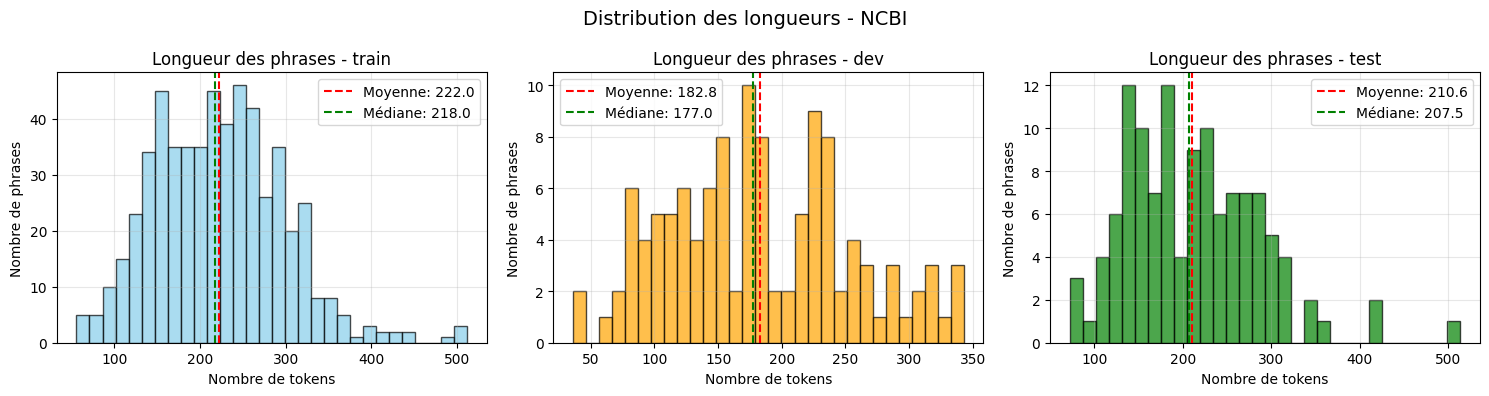


3. DISTRIBUTION DES CLASSES D'ENTITÉS
----------------------------------------

Fréquences absolues:
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                       114,135     19,827     23,539
B-Disease                 4,324        798        821
I-Disease                 4,747        949        907

Pourcentages (par split):
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                         92.6%      91.9%      93.2%
B-Disease                  3.5%       3.7%       3.2%
I-Disease                  3.9%       4.4%       3.6%

4. VISUALISATION DES ENTITÉS (sans 'O')


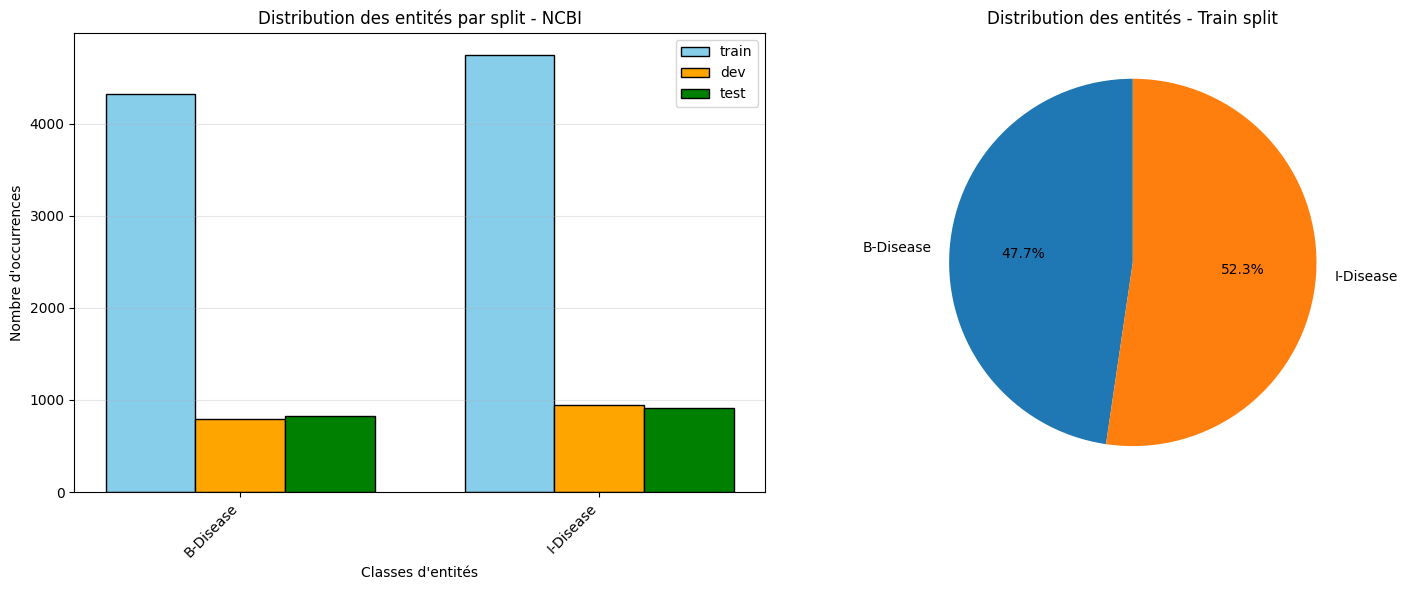


5. ENTITÉS PAR PHRASE
----------------------------------------

TRAIN:
  Entités/phrase (moyenne): 16.34
  Entités/phrase (médiane): 14.0
  Phrases sans entité: 1 (0.2%)

DEV:
  Entités/phrase (moyenne): 14.81
  Entités/phrase (médiane): 12.5
  Phrases sans entité: 0 (0.0%)

TEST:
  Entités/phrase (moyenne): 14.40
  Entités/phrase (médiane): 12.0
  Phrases sans entité: 0 (0.0%)


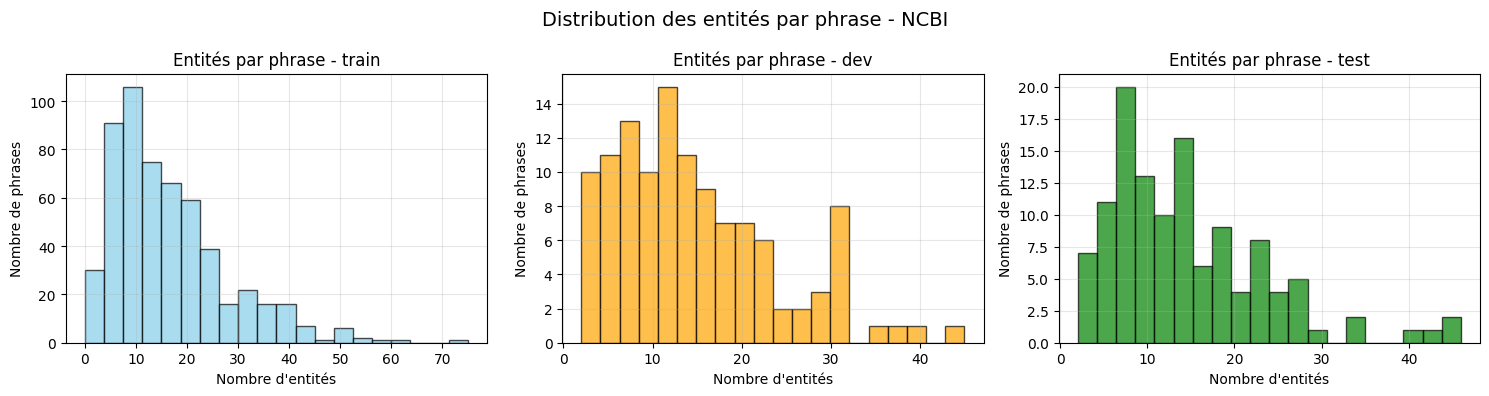


6. ANALYSE DES TAGS BIO
----------------------------------------
Total des tags: 170,047
  B: 5,943 (3.5%)
  I: 6,603 (3.9%)
  O: 157,501 (92.6%)
  autres: 0 (0.0%)

7. INFORMATIONS SUPPLÉMENTAIRES
----------------------------------------
Taille du vocabulaire: 5,747 mots
Taille du vocabulaire caractères: 86
Nombre de classes uniques: 4
Classes: ['<PAD>', 'B-Disease', 'I-Disease', 'O']

ANALYSE TERMINÉE


In [5]:
results_ncbi_standard = convert_to_standard_format(results_ncbi)
visualize_dataset_distribution(results_ncbi_standard, dataset_name="NCBI")

Création de dataset JNLPBA

Model architecture

In [6]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)
        optimizer.zero_grad()
        # Passer les tags -> forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, idx_to_tag):
    """
    Evaluate model (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss (tags fournis)
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list
            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor -> numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculate precision, recall, F1-score
    """
    
    
    # Filter out 'O' tags for entity-specific metrics
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


NCBI Dataset

In [7]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    embedding_url: str = None,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 40,
    patience: int = 4,   
    checkpoints_dir="./checkpoints",
):
    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']

    comb_name = "WE"
    if use_char_cnn and use_char_lstm:
        comb_name += "_char_bilstm_cnn"
    elif use_char_cnn:
        comb_name += "_char_cnn"
    elif use_char_lstm:
        comb_name += "_char_bilstm"

    if use_attention:
        comb_name += "_attention"
    if use_fc_fusion:
        comb_name += "_fc"

    checkpoints_path = f"{checkpoints_dir}/{comb_name}/best_model.pt"
    os.makedirs(os.path.dirname(checkpoints_path), exist_ok=True)

    # Chargement des embeddings
    if embedding_url:
        pretrained_embeddings = load_word2vec_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        pretrained_embeddings = loaders['pretrained_embeddings']
    else:
        print("Embedding nul")
        return

    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        dataset=dataset_name,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Adam optimizer avec L2 / weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Scheduler manuel: decay rate selon dataset
    decay_rate = 0.90 if dataset_name == 'JNLPBA' else 0.95

    best_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [], 'dev_loss': [], 'dev_f1': [],
        'dev_precision': [], 'dev_recall': [], 'lr': []
    }

    for epoch in range(epochs):
        # 1. Train
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # 2. Eval
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)

        # 3. Appliquer decay rate
        for g in optimizer.param_groups:
            g['lr'] *= decay_rate

        # 4. Historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['dev_precision'].append(precision)
        history['dev_recall'].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # 5. Early stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé: F1 {f1:.4f} ({checkpoints_path})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered après {epoch+1} epochs.")
            break

    # Charger meilleur modèle
    checkpoint = torch.load(checkpoints_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_preds, test_targets = evaluate(model, test_loader, device, idx_to_tag)
    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)

    return model, history


## Combinaison 1:  WE

In [8]:
model_ncbi_we, history_ncbi_we = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,391,828


Training: 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 01/40 | Train loss: 4030.4874 | Dev loss: 2034.0748 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:04<00:00,  4.49it/s]


Epoch 02/40 | Train loss: 1894.5125 | Dev loss: 1556.5142 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


Epoch 03/40 | Train loss: 1616.3141 | Dev loss: 1373.9558 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:03<00:00,  4.70it/s]


Epoch 04/40 | Train loss: 1375.2499 | Dev loss: 1159.2999 | P: 0.3333 R: 0.0128 F1: 0.0246 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.0246


Training: 100%|██████████| 18/18 [00:04<00:00,  4.40it/s]


Epoch 05/40 | Train loss: 1101.3883 | Dev loss: 956.5420 | P: 0.4625 R: 0.1340 F1: 0.1706 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.1706


Training: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]


Epoch 06/40 | Train loss: 913.1793 | Dev loss: 828.7272 | P: 0.5001 R: 0.1979 F1: 0.2536 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.2536


Training: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


Epoch 07/40 | Train loss: 768.3766 | Dev loss: 749.1339 | P: 0.4817 R: 0.2934 F1: 0.3340 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.3340


Training: 100%|██████████| 18/18 [00:03<00:00,  4.50it/s]


Epoch 08/40 | Train loss: 661.5354 | Dev loss: 682.9178 | P: 0.4830 R: 0.3527 F1: 0.3970 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.3970


Training: 100%|██████████| 18/18 [00:04<00:00,  4.28it/s]


Epoch 09/40 | Train loss: 579.3299 | Dev loss: 635.1856 | P: 0.5070 R: 0.3927 F1: 0.4393 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4393


Training: 100%|██████████| 18/18 [00:04<00:00,  4.49it/s]


Epoch 10/40 | Train loss: 509.3642 | Dev loss: 603.0055 | P: 0.5155 R: 0.3863 F1: 0.4404 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4404


Training: 100%|██████████| 18/18 [00:04<00:00,  4.38it/s]


Epoch 11/40 | Train loss: 457.3640 | Dev loss: 573.2380 | P: 0.5077 R: 0.4334 F1: 0.4665 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4665


Training: 100%|██████████| 18/18 [00:04<00:00,  4.29it/s]


Epoch 12/40 | Train loss: 409.6312 | Dev loss: 553.0006 | P: 0.5150 R: 0.4445 F1: 0.4770 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4770


Training: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


Epoch 13/40 | Train loss: 371.3951 | Dev loss: 536.3342 | P: 0.5240 R: 0.4427 F1: 0.4795 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.4795


Training: 100%|██████████| 18/18 [00:03<00:00,  4.73it/s]


Epoch 14/40 | Train loss: 344.7931 | Dev loss: 521.5924 | P: 0.5244 R: 0.4621 F1: 0.4911 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.4911


Training: 100%|██████████| 18/18 [00:04<00:00,  4.34it/s]


Epoch 15/40 | Train loss: 312.3131 | Dev loss: 524.5942 | P: 0.5083 R: 0.4773 F1: 0.4919 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.4919


Training: 100%|██████████| 18/18 [00:04<00:00,  4.38it/s]


Epoch 16/40 | Train loss: 290.0252 | Dev loss: 540.0276 | P: 0.4844 R: 0.5016 F1: 0.4925 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.4925


Training: 100%|██████████| 18/18 [00:04<00:00,  4.48it/s]


Epoch 17/40 | Train loss: 273.7646 | Dev loss: 502.5646 | P: 0.5314 R: 0.4636 F1: 0.4952 | LR: 0.000418
Meilleur modèle sauvegardé: F1 0.4952


Training: 100%|██████████| 18/18 [00:04<00:00,  4.46it/s]


Epoch 18/40 | Train loss: 257.0436 | Dev loss: 497.7983 | P: 0.5229 R: 0.4759 F1: 0.4979 | LR: 0.000397
Meilleur modèle sauvegardé: F1 0.4979


Training: 100%|██████████| 18/18 [00:04<00:00,  4.38it/s]


Epoch 19/40 | Train loss: 238.2109 | Dev loss: 513.2460 | P: 0.4934 R: 0.4976 F1: 0.4951 | LR: 0.000377


Training: 100%|██████████| 18/18 [00:04<00:00,  4.42it/s]


Epoch 20/40 | Train loss: 225.0462 | Dev loss: 497.7427 | P: 0.5101 R: 0.4849 F1: 0.4972 | LR: 0.000358


Training: 100%|██████████| 18/18 [00:04<00:00,  4.43it/s]


Epoch 21/40 | Train loss: 210.9351 | Dev loss: 497.8998 | P: 0.5177 R: 0.4744 F1: 0.4951 | LR: 0.000341


Training: 100%|██████████| 18/18 [00:04<00:00,  4.40it/s]


Epoch 22/40 | Train loss: 199.8553 | Dev loss: 509.5575 | P: 0.4970 R: 0.4997 F1: 0.4982 | LR: 0.000324
Meilleur modèle sauvegardé: F1 0.4982


Training: 100%|██████████| 18/18 [00:04<00:00,  4.43it/s]


Epoch 23/40 | Train loss: 189.4689 | Dev loss: 511.3887 | P: 0.4989 R: 0.4906 F1: 0.4945 | LR: 0.000307


Training: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


Epoch 24/40 | Train loss: 179.3889 | Dev loss: 507.2790 | P: 0.5031 R: 0.5000 F1: 0.5011 | LR: 0.000292
Meilleur modèle sauvegardé: F1 0.5011


Training: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


Epoch 25/40 | Train loss: 170.7040 | Dev loss: 503.0189 | P: 0.5218 R: 0.4888 F1: 0.5045 | LR: 0.000277
Meilleur modèle sauvegardé: F1 0.5045


Training: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s]


Epoch 26/40 | Train loss: 162.7287 | Dev loss: 502.1283 | P: 0.5176 R: 0.4954 F1: 0.5061 | LR: 0.000264
Meilleur modèle sauvegardé: F1 0.5061


Training: 100%|██████████| 18/18 [00:03<00:00,  4.53it/s]


Epoch 27/40 | Train loss: 155.1157 | Dev loss: 506.5545 | P: 0.5246 R: 0.4888 F1: 0.5060 | LR: 0.000250


Training: 100%|██████████| 18/18 [00:03<00:00,  4.57it/s]


Epoch 28/40 | Train loss: 148.5894 | Dev loss: 551.1069 | P: 0.4831 R: 0.5117 F1: 0.4966 | LR: 0.000238


Training: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


Epoch 29/40 | Train loss: 144.5457 | Dev loss: 531.1727 | P: 0.4975 R: 0.5072 F1: 0.5020 | LR: 0.000226


Training: 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]


Epoch 30/40 | Train loss: 138.6846 | Dev loss: 511.7318 | P: 0.5210 R: 0.4888 F1: 0.5042 | LR: 0.000215
Early stopping triggered après 30 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 404.8188
Precision: 0.5559
Recall: 0.5387
F1-score: 0.5471


In [8]:
def print_model_layers(model: torch.nn.Module):
    print(f"{'Layer (type)':30} | {'Param #':>12}")
    print("-"*45)
    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0: 
            param_count = sum(p.numel() for p in module.parameters())
            print(f"{name + ' (' + module.__class__.__name__ + ')':30} | {param_count:12,}")
            total_params += param_count
    print("-"*45)
    print(f"{'Total parameters':30} | {total_params:12,}")


In [10]:
print_model_layers(model_ncbi_we)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
context_lstm (LSTM)            |      241,600
emission (Linear)              |          804
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,391,828


In [6]:
import pickle
import os

def save_vocabularies(data_dict, save_dir):
    """Sauvegarde les vocabulaires et mappings"""
    os.makedirs(save_dir, exist_ok=True)
    
    with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['vocab'], f)
    
    with open(os.path.join(save_dir, 'char_vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['char_vocab'], f)
    
    with open(os.path.join(save_dir, 'tag_to_idx.pkl'), 'wb') as f:
        pickle.dump(data_dict['tag_to_idx'], f)
    
    with open(os.path.join(save_dir, 'idx_to_tag.pkl'), 'wb') as f:
        pickle.dump(data_dict['idx_to_tag'], f)
    
    print(f"Vocabulaires sauvegardés dans {save_dir}")
    
save_vocabularies(results_ncbi, './vocab/ncbi')

Vocabulaires sauvegardés dans ./vocab/ncbi


In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1 (double axis)
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2,color="red")
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2,color="green")

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


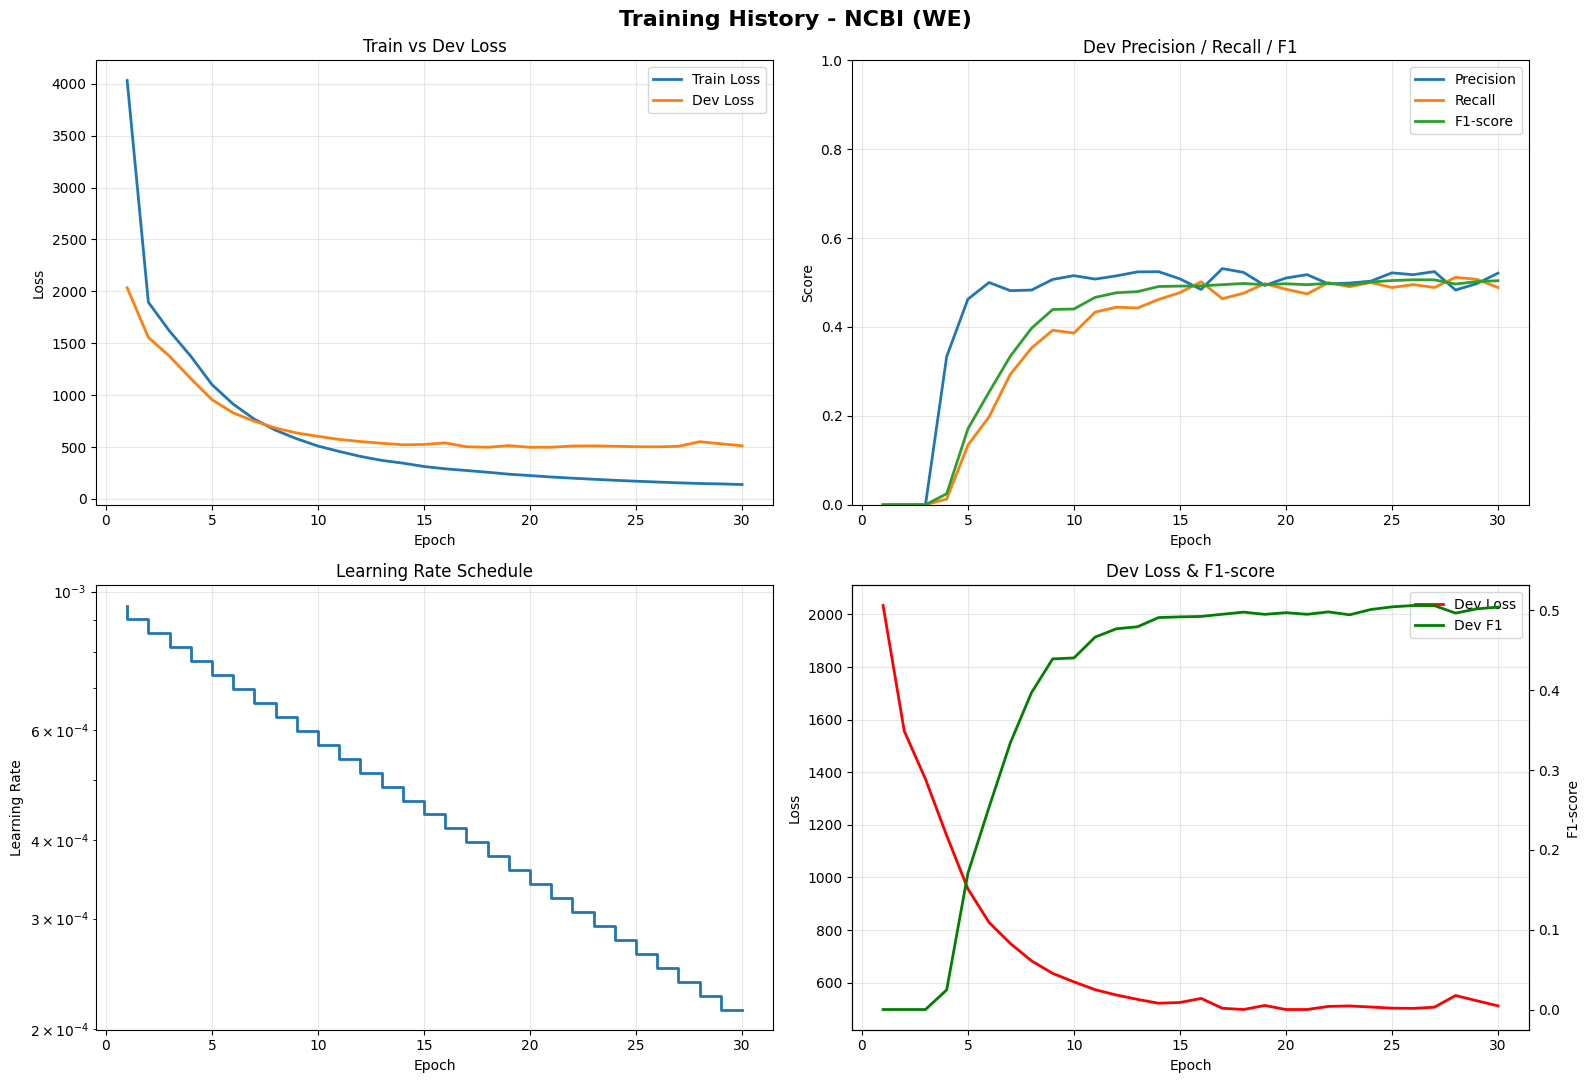


STATISTIQUES FINALES - NCBI (WE)
Meilleur F1 (dev)       : 0.5061
Meilleure Precision(dev): 0.5314
Meilleur Recall (dev)   : 0.5117
Final train loss        : 138.6846
Final dev loss          : 511.7318
Final learning rate     : 0.000215


In [13]:
plot_training_history(history_ncbi_we, dataset_name="NCBI (WE)")

In [11]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
    dataset=dataset_name,
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=use_char_cnn,       
    use_char_lstm=use_char_lstm,      
    use_attention=use_attention,     
    use_fc_fusion=use_fc_fusion,  
    pretrained_embeddings=None,  
    word_embed_dim=200,
    lstm_hidden_dim=lstm_hidden,
    dropout=0.5
).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag

def plot_confusion_matrix_by_class(predictions, targets, idx_to_tag, dataset_name, 
                                   normalize=True, figsize=(12, 10),title="Matrice de confusion"):
    """
    Affiche la matrice de confusion par classe avec des statistiques détaillées
    """
    # Vérification des types
    print(f"\nVérification des types:")
    print(f"  Type predictions[0]: {type(predictions[0])}, valeur: {predictions[0]}")
    print(f"  Type targets[0]: {type(targets[0])}, valeur: {targets[0]}")
    
    # S'assurer que tout est string
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]
    
    print(f"\nStatistiques:")
    print(f"  Total tokens: {len(predictions)}")
    print(f"  Entity tokens: {len(targets)}")
    print(f"  Unique entity tags in targets: {set(targets)}")
    print(f"  Unique entity tags in predictions: {set(predictions)}")
    all_unique_tags = sorted(set(targets + predictions))
    
    # Filtrer pour garder seulement les tags valides (pas les nombres)
    valid_tags = [tag for tag in all_unique_tags if not tag.isdigit()]
    
    # Si on a des tags numériques, c'est qu'il y a un problème de conversion
    numeric_tags = [tag for tag in all_unique_tags if tag.isdigit()]
    if numeric_tags:
        print(f"\nATTENTION: Tags numériques trouvés: {numeric_tags}")
        print("Cela indique que les prédictions sont des indices, pas des tags!")
        print(f"Mapping idx_to_tag: {dict(list(idx_to_tag.items())[:10])}")
    
    print(f"  Tags valides à plotter: {valid_tags}")
    
    if not valid_tags:
        print("Aucune entité valide trouvée dans les données!")
        return

    cm = confusion_matrix(targets, predictions, labels=valid_tags)
    supports = cm.sum(axis=1)  
    
    if normalize:
        # Éviter la division par zéro
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = cm.astype('float') / supports[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)
        cm_to_plot = cm_normalized
        fmt = '.2f'
    else:
        cm_to_plot = cm
        fmt = 'd'
    
    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Si la matrice est trop grande, ajuster la taille
    if len(valid_tags) > 15:
        figsize = (max(12, len(valid_tags)), max(10, len(valid_tags)))
        plt.figure(figsize=figsize)
    
    sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=valid_tags, yticklabels=valid_tags,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    
    plt.title(title,fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    filtered_targets = []
    filtered_preds = []
    
    for t, p in zip(targets, predictions):
        if t in valid_tags and p in valid_tags:
            filtered_targets.append(t)
            filtered_preds.append(p)
    
    if filtered_targets:
        report = classification_report(filtered_targets, filtered_preds, 
                                       labels=valid_tags, zero_division=0)
        print(report)
    else:
        print("Pas assez de données pour générer le rapport")

def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


In [15]:
model_path = "./checkpoints/NCBI/we/best_model.pt"
model, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_ncbi['test_loader']
predictions, targets = predict_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/we/best_model.pt
Best F1 enregistré: 0.5061
Époque: 25
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O                  | O          


Accuracy globale: 0.9776

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'I-Disease', 'O', 'B-Disease'}
  Unique entity tags in predictions: {'I-Disease', 'O', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


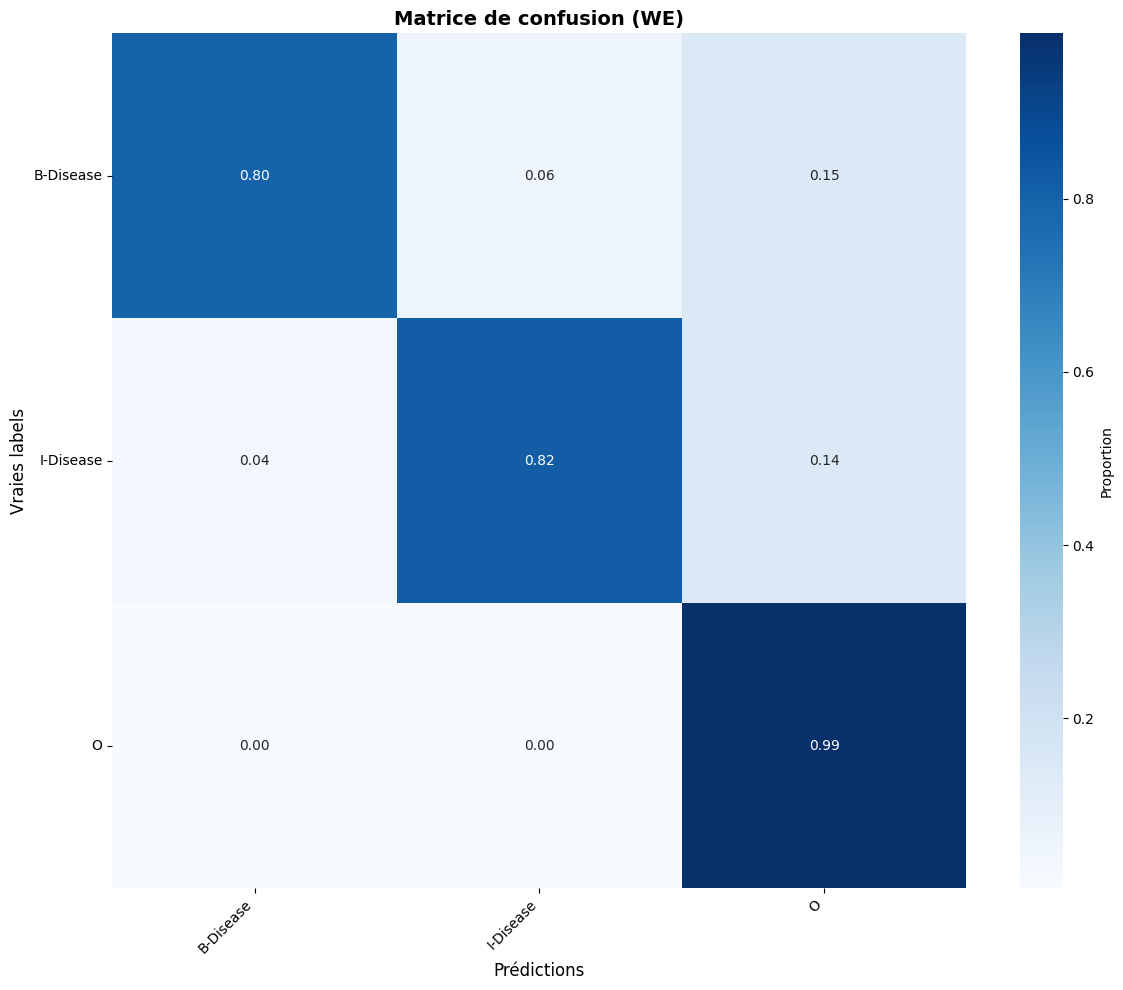

              precision    recall  f1-score   support

   B-Disease       0.82      0.80      0.81       720
   I-Disease       0.85      0.82      0.83       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.89      0.87      0.88     21017
weighted avg       0.98      0.98      0.98     21017



In [16]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets, predictions)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions) == set(targets) or all(isinstance(p, str) for p in predictions):
    plot_confusion_matrix_by_class(
        predictions=predictions,
        targets=targets,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets[:10])}")

## Combinaison 2:  WE + attention

In [17]:
model_we_attention, history_we_attention = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 1,319,156


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Epoch 01/40 | Train loss: 3709.3782 | Dev loss: 1858.6941 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]


Epoch 02/40 | Train loss: 1828.0716 | Dev loss: 1522.8706 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:06<00:00,  2.88it/s]


Epoch 03/40 | Train loss: 1546.8201 | Dev loss: 1249.4877 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:06<00:00,  2.89it/s]


Epoch 04/40 | Train loss: 1164.1454 | Dev loss: 975.3177 | P: 0.4545 R: 0.1280 F1: 0.1592 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.1592


Training: 100%|██████████| 18/18 [00:06<00:00,  2.90it/s]


Epoch 05/40 | Train loss: 913.0490 | Dev loss: 816.1455 | P: 0.4433 R: 0.2525 F1: 0.2979 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.2979


Training: 100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Epoch 06/40 | Train loss: 733.1631 | Dev loss: 705.4373 | P: 0.4336 R: 0.2918 F1: 0.3461 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.3461


Training: 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]


Epoch 07/40 | Train loss: 597.3057 | Dev loss: 641.5533 | P: 0.4649 R: 0.4125 F1: 0.4370 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4370


Training: 100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Epoch 08/40 | Train loss: 495.6590 | Dev loss: 580.9091 | P: 0.4998 R: 0.4282 F1: 0.4613 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4613


Training: 100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


Epoch 09/40 | Train loss: 416.4758 | Dev loss: 540.0752 | P: 0.5197 R: 0.4546 F1: 0.4847 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4847


Training: 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


Epoch 10/40 | Train loss: 355.9131 | Dev loss: 517.1712 | P: 0.5335 R: 0.4531 F1: 0.4897 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4897


Training: 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Epoch 11/40 | Train loss: 308.1671 | Dev loss: 513.5059 | P: 0.5365 R: 0.4570 F1: 0.4917 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4917


Training: 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]


Epoch 12/40 | Train loss: 271.3433 | Dev loss: 500.9809 | P: 0.5349 R: 0.4665 F1: 0.4977 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4977


Training: 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]


Epoch 13/40 | Train loss: 235.8369 | Dev loss: 499.8135 | P: 0.5242 R: 0.4960 F1: 0.5091 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.5091


Training: 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]


Epoch 14/40 | Train loss: 208.0596 | Dev loss: 501.7051 | P: 0.5228 R: 0.4973 F1: 0.5086 | LR: 0.000488


Training: 100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Epoch 15/40 | Train loss: 182.9294 | Dev loss: 525.8630 | P: 0.5307 R: 0.4702 F1: 0.4978 | LR: 0.000463


Training: 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Epoch 16/40 | Train loss: 161.7346 | Dev loss: 528.2375 | P: 0.5046 R: 0.5067 F1: 0.5055 | LR: 0.000440


Training: 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Epoch 17/40 | Train loss: 143.3389 | Dev loss: 543.2194 | P: 0.5238 R: 0.4742 F1: 0.4967 | LR: 0.000418
Early stopping triggered après 17 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 396.6982
Precision: 0.5591
Recall: 0.5266
F1-score: 0.5424


In [18]:
print_model_layers(model_we_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
context_lstm (LSTM)            |      136,192
attention_layer.W (Linear)     |          128
attention_projection (Linear)  |       32,896
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,319,156


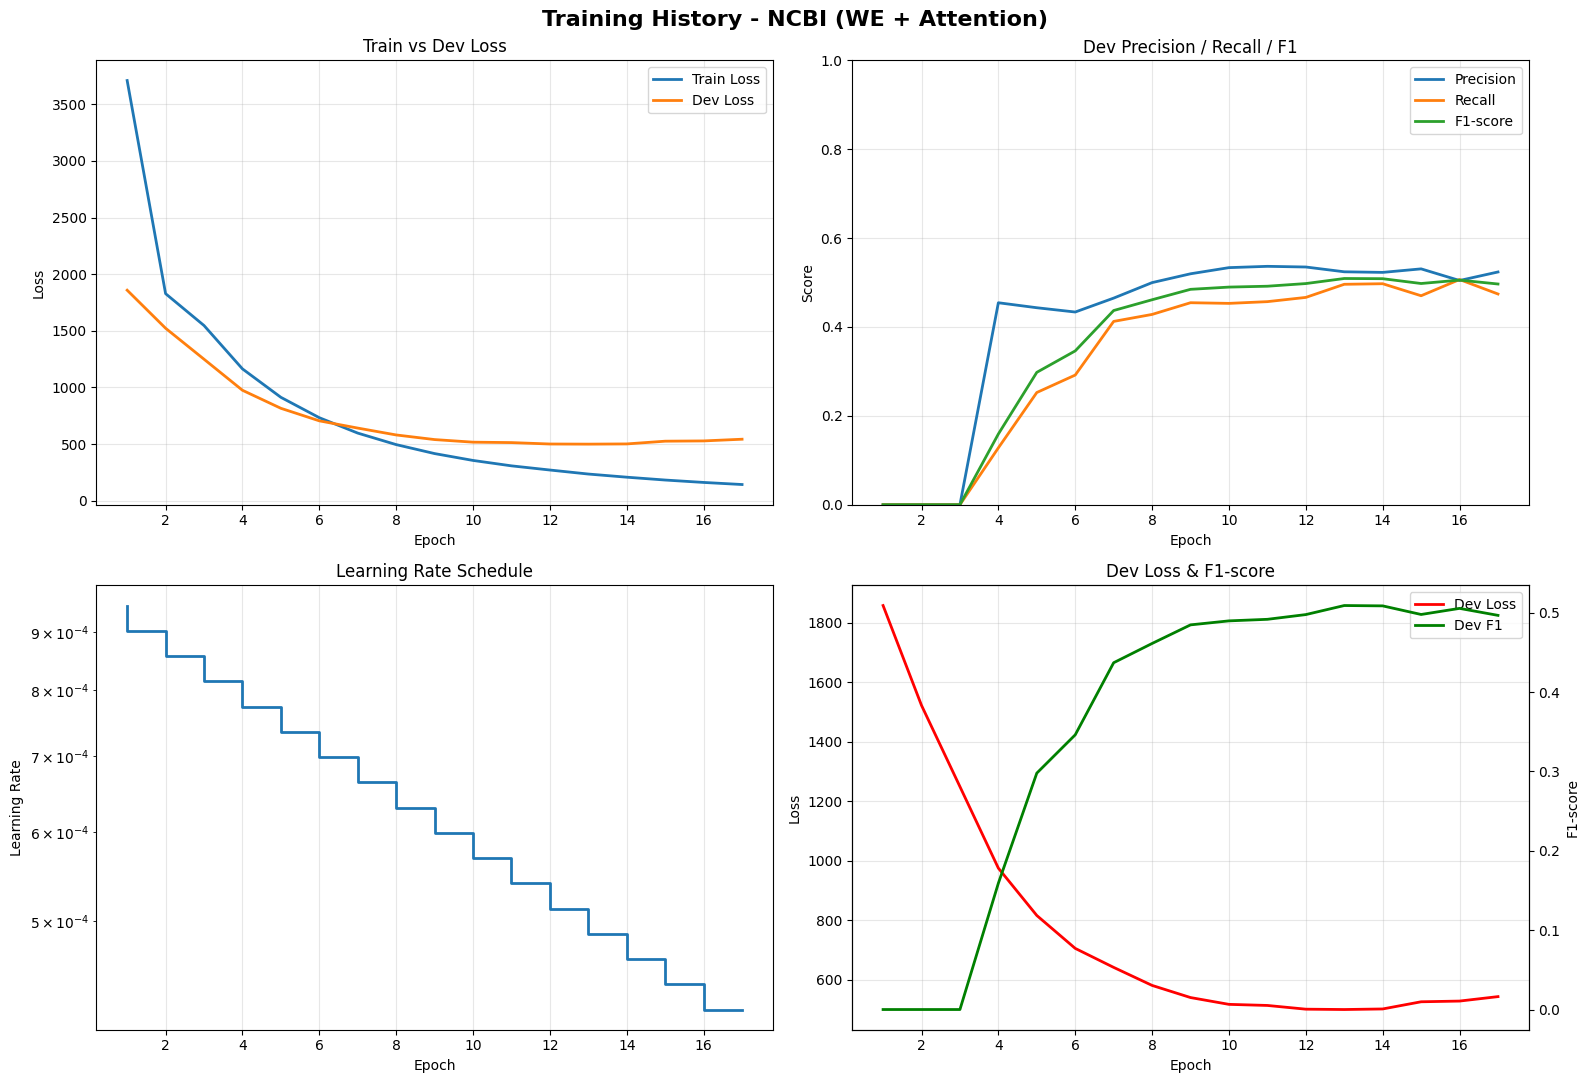


STATISTIQUES FINALES - NCBI (WE + Attention)
Meilleur F1 (dev)       : 0.5091
Meilleure Precision(dev): 0.5365
Meilleur Recall (dev)   : 0.5067
Final train loss        : 143.3389
Final dev loss          : 543.2194
Final learning rate     : 0.000418


In [19]:
plot_training_history(history_we_attention, dataset_name="NCBI (WE + Attention)")

In [20]:
model_path = "./checkpoints/NCBI/WE_attention/best_model.pt"
model_we_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_ncbi['test_loader']
predictions_we_attention, targets_we_attention = predict_on_test_set(
    model=model_we_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_attention/best_model.pt
Best F1 enregistré: 0.5091
Époque: 12
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O                  | O


Accuracy globale: 0.9770

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'I-Disease', 'O', 'B-Disease'}
  Unique entity tags in predictions: {'I-Disease', 'O', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


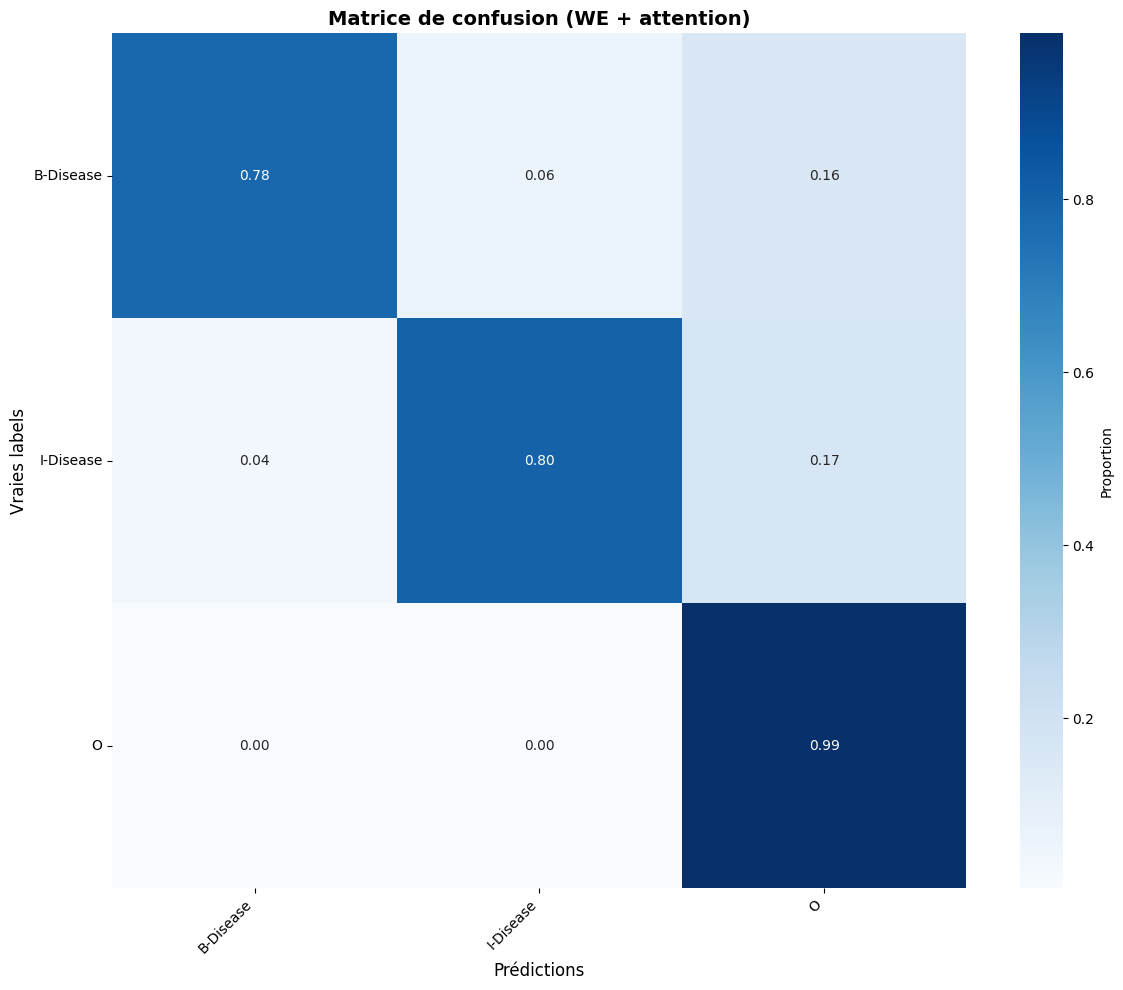

              precision    recall  f1-score   support

   B-Disease       0.84      0.78      0.81       720
   I-Disease       0.84      0.80      0.82       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.89      0.86      0.87     21017
weighted avg       0.98      0.98      0.98     21017



In [21]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_attention, predictions_we_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_attention) == set(targets_we_attention) or all(isinstance(p, str) for p in predictions_we_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_attention,
        targets=targets_we_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_attention[:10])}")

## Combinaison 3:  WE + char(bi-lstm)

In [23]:
model_we_char_bilstm , history_we_char_bilstm = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 1,382,432


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 01/40 | Train loss: 3485.3377 | Dev loss: 1809.2956 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


Epoch 02/40 | Train loss: 1917.8220 | Dev loss: 1605.0252 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


Epoch 03/40 | Train loss: 1711.3696 | Dev loss: 1459.3489 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]


Epoch 04/40 | Train loss: 1524.8462 | Dev loss: 1276.6284 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000815


Training: 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]


Epoch 05/40 | Train loss: 1248.1809 | Dev loss: 1038.4694 | P: 0.2827 R: 0.0259 F1: 0.0475 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.0475


Training: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s]


Epoch 06/40 | Train loss: 977.6244 | Dev loss: 862.4537 | P: 0.4804 R: 0.1498 F1: 0.2137 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.2137


Training: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s]


Epoch 07/40 | Train loss: 788.1479 | Dev loss: 752.4809 | P: 0.4811 R: 0.2730 F1: 0.3469 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.3469


Training: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s]


Epoch 08/40 | Train loss: 656.8371 | Dev loss: 678.7061 | P: 0.4941 R: 0.3624 F1: 0.4181 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4181


Training: 100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Epoch 09/40 | Train loss: 562.4527 | Dev loss: 623.6750 | P: 0.5218 R: 0.3815 F1: 0.4406 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4406


Training: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Epoch 10/40 | Train loss: 490.2312 | Dev loss: 582.4256 | P: 0.5101 R: 0.4283 F1: 0.4656 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4656


Training: 100%|██████████| 18/18 [00:05<00:00,  3.45it/s]


Epoch 11/40 | Train loss: 431.1255 | Dev loss: 542.8202 | P: 0.5251 R: 0.4354 F1: 0.4760 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4760


Training: 100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


Epoch 12/40 | Train loss: 383.1214 | Dev loss: 516.5883 | P: 0.5301 R: 0.4428 F1: 0.4825 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4825


Training: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 13/40 | Train loss: 346.3146 | Dev loss: 494.7951 | P: 0.5293 R: 0.4667 F1: 0.4960 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.4960


Training: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


Epoch 14/40 | Train loss: 316.4363 | Dev loss: 482.5089 | P: 0.5418 R: 0.4583 F1: 0.4966 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.4966


Training: 100%|██████████| 18/18 [00:20<00:00,  1.11s/it]


Epoch 15/40 | Train loss: 293.0868 | Dev loss: 474.3501 | P: 0.5266 R: 0.4851 F1: 0.5050 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.5050


Training: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


Epoch 16/40 | Train loss: 270.6701 | Dev loss: 465.5639 | P: 0.5390 R: 0.4751 F1: 0.5050 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.5050


Training: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


Epoch 17/40 | Train loss: 252.5472 | Dev loss: 479.0757 | P: 0.5059 R: 0.5026 F1: 0.5043 | LR: 0.000418


Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 18/40 | Train loss: 240.4097 | Dev loss: 456.8024 | P: 0.5387 R: 0.4938 F1: 0.5153 | LR: 0.000397
Meilleur modèle sauvegardé: F1 0.5153


Training: 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]


Epoch 19/40 | Train loss: 224.2884 | Dev loss: 453.0481 | P: 0.5345 R: 0.5010 F1: 0.5171 | LR: 0.000377
Meilleur modèle sauvegardé: F1 0.5171


Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 20/40 | Train loss: 214.6597 | Dev loss: 448.8359 | P: 0.5321 R: 0.5027 F1: 0.5168 | LR: 0.000358


Training: 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 21/40 | Train loss: 204.5593 | Dev loss: 452.9389 | P: 0.5355 R: 0.5030 F1: 0.5186 | LR: 0.000341
Meilleur modèle sauvegardé: F1 0.5186


Training: 100%|██████████| 18/18 [00:04<00:00,  3.92it/s]


Epoch 22/40 | Train loss: 192.9450 | Dev loss: 446.3595 | P: 0.5314 R: 0.5115 F1: 0.5211 | LR: 0.000324
Meilleur modèle sauvegardé: F1 0.5211


Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 23/40 | Train loss: 184.6159 | Dev loss: 443.5506 | P: 0.5419 R: 0.5061 F1: 0.5233 | LR: 0.000307
Meilleur modèle sauvegardé: F1 0.5233


Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 24/40 | Train loss: 178.6840 | Dev loss: 468.6859 | P: 0.5172 R: 0.5241 F1: 0.5204 | LR: 0.000292


Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 25/40 | Train loss: 170.4760 | Dev loss: 443.2116 | P: 0.5447 R: 0.5049 F1: 0.5239 | LR: 0.000277
Meilleur modèle sauvegardé: F1 0.5239


Training: 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 26/40 | Train loss: 164.1868 | Dev loss: 465.0101 | P: 0.5180 R: 0.5200 F1: 0.5187 | LR: 0.000264


Training: 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]


Epoch 27/40 | Train loss: 157.6668 | Dev loss: 449.4250 | P: 0.5289 R: 0.5154 F1: 0.5220 | LR: 0.000250


Training: 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]


Epoch 28/40 | Train loss: 151.2928 | Dev loss: 455.5104 | P: 0.5285 R: 0.5177 F1: 0.5228 | LR: 0.000238


Training: 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]


Epoch 29/40 | Train loss: 145.8957 | Dev loss: 457.6355 | P: 0.5274 R: 0.5192 F1: 0.5231 | LR: 0.000226


Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 30/40 | Train loss: 142.7465 | Dev loss: 448.0653 | P: 0.5362 R: 0.5153 F1: 0.5254 | LR: 0.000215
Meilleur modèle sauvegardé: F1 0.5254


Training: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 31/40 | Train loss: 137.0830 | Dev loss: 470.5537 | P: 0.5161 R: 0.5220 F1: 0.5187 | LR: 0.000204


Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 32/40 | Train loss: 134.8885 | Dev loss: 461.6214 | P: 0.5258 R: 0.5171 F1: 0.5213 | LR: 0.000194


Training: 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 33/40 | Train loss: 130.2204 | Dev loss: 455.8068 | P: 0.5329 R: 0.5182 F1: 0.5253 | LR: 0.000184


Training: 100%|██████████| 18/18 [00:04<00:00,  3.95it/s]


Epoch 34/40 | Train loss: 126.8543 | Dev loss: 454.3689 | P: 0.5296 R: 0.5192 F1: 0.5240 | LR: 0.000175


Training: 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 35/40 | Train loss: 123.2549 | Dev loss: 463.3158 | P: 0.5226 R: 0.5210 F1: 0.5214 | LR: 0.000166


Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 36/40 | Train loss: 120.1297 | Dev loss: 466.7946 | P: 0.5213 R: 0.5215 F1: 0.5210 | LR: 0.000158


Training: 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]


Epoch 37/40 | Train loss: 117.7539 | Dev loss: 465.7219 | P: 0.5171 R: 0.5241 F1: 0.5202 | LR: 0.000150


Training: 100%|██████████| 18/18 [00:04<00:00,  3.85it/s]


Epoch 38/40 | Train loss: 114.8389 | Dev loss: 461.9103 | P: 0.5228 R: 0.5227 F1: 0.5224 | LR: 0.000142
Early stopping triggered après 38 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 381.9819
Precision: 0.5543
Recall: 0.5471
F1-score: 0.5507


In [24]:
print_model_layers(model_we_char_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      187,392
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,382,432


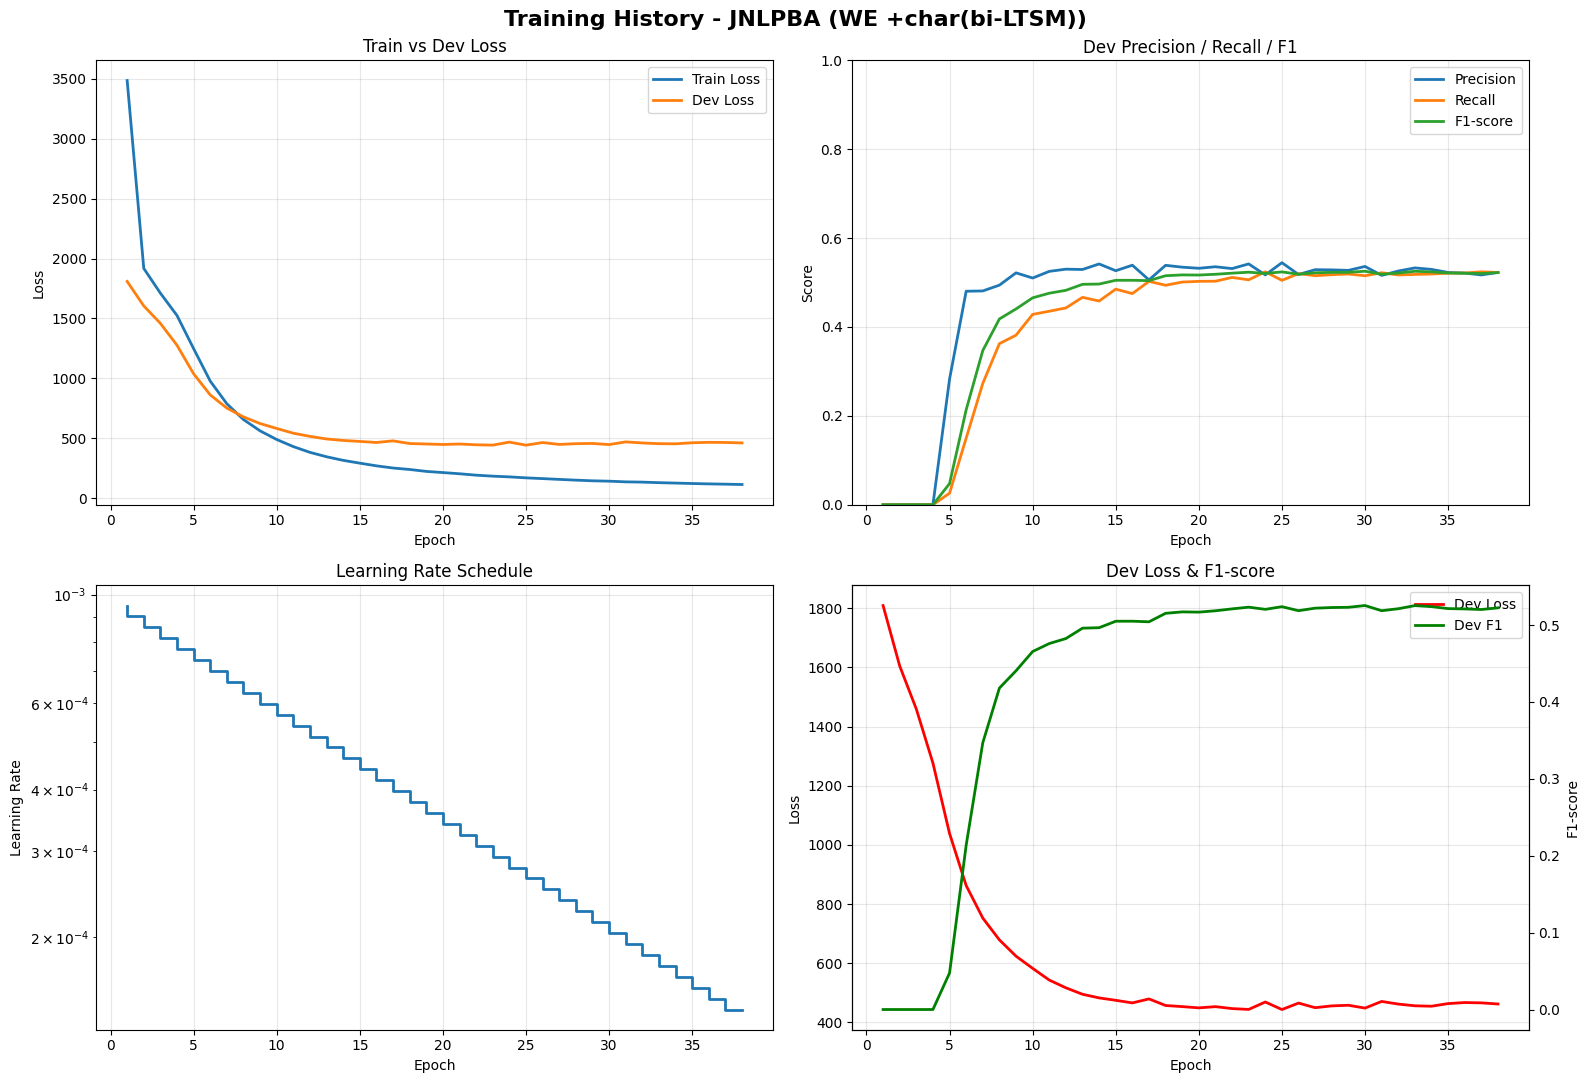


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM))
Meilleur F1 (dev)       : 0.5254
Meilleure Precision(dev): 0.5447
Meilleur Recall (dev)   : 0.5241
Final train loss        : 114.8389
Final dev loss          : 461.9103
Final learning rate     : 0.000142


In [25]:
plot_training_history(history_we_char_bilstm, dataset_name="JNLPBA (WE +char(bi-LTSM))")

In [26]:
model_path = "./checkpoints/NCBI/WE_char_bilstm/best_model.pt"
model_we_char_bilstm , device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)

test_loader = results_ncbi['test_loader']
predictions_we_char, targets_we_char = predict_on_test_set(
    model=model_we_char_bilstm ,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm/best_model.pt
Best F1 enregistré: 0.5254
Époque: 29
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O                  |


Accuracy globale: 0.9780

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'I-Disease', 'O', 'B-Disease'}
  Unique entity tags in predictions: {'I-Disease', 'O', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


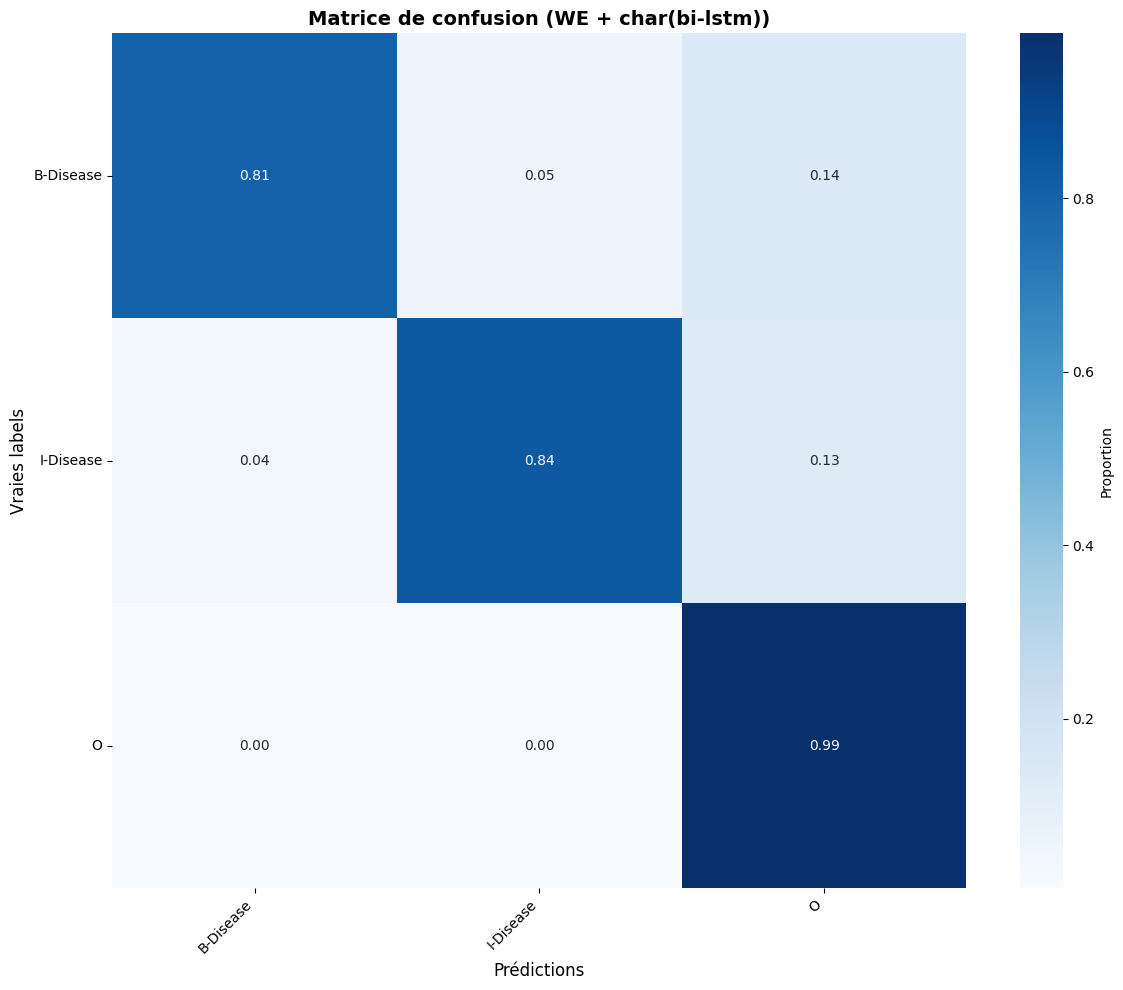

              precision    recall  f1-score   support

   B-Disease       0.83      0.81      0.82       720
   I-Disease       0.84      0.84      0.84       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.88      0.88      0.88     21017
weighted avg       0.98      0.98      0.98     21017



In [27]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char, predictions_we_char)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char) == set(targets_we_char) or all(isinstance(p, str) for p in predictions_we_char):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char,
        targets=targets_we_char,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char[:10])}")

## Combinaison 4:  WE + char(bi-lstm) + attention

In [28]:
model_we_char_attention, history_we_char_attention = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,415,456


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


Epoch 01/40 | Train loss: 3169.6718 | Dev loss: 1632.9694 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:07<00:00,  2.57it/s]


Epoch 02/40 | Train loss: 1826.5245 | Dev loss: 1547.8712 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Epoch 03/40 | Train loss: 1623.0259 | Dev loss: 1278.7511 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Epoch 04/40 | Train loss: 1177.6886 | Dev loss: 941.2562 | P: 0.5155 R: 0.1736 F1: 0.1792 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.1792


Training: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]


Epoch 05/40 | Train loss: 875.9349 | Dev loss: 813.8492 | P: 0.4372 R: 0.3060 F1: 0.3439 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.3439


Training: 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Epoch 06/40 | Train loss: 706.7958 | Dev loss: 714.8933 | P: 0.4726 R: 0.3516 F1: 0.4030 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4030


Training: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


Epoch 07/40 | Train loss: 585.3370 | Dev loss: 654.9951 | P: 0.4797 R: 0.3818 F1: 0.4250 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4250


Training: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Epoch 08/40 | Train loss: 490.5045 | Dev loss: 620.6949 | P: 0.4923 R: 0.3859 F1: 0.4290 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4290


Training: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Epoch 09/40 | Train loss: 415.7637 | Dev loss: 574.0109 | P: 0.5073 R: 0.4126 F1: 0.4530 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4530


Training: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Epoch 10/40 | Train loss: 347.3980 | Dev loss: 532.0362 | P: 0.5166 R: 0.4476 F1: 0.4792 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4792


Training: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Epoch 11/40 | Train loss: 299.1402 | Dev loss: 507.3240 | P: 0.5281 R: 0.4573 F1: 0.4902 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4902


Training: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Epoch 12/40 | Train loss: 261.6682 | Dev loss: 500.4676 | P: 0.5096 R: 0.4738 F1: 0.4904 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4904


Training: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Epoch 13/40 | Train loss: 229.9644 | Dev loss: 493.1595 | P: 0.5320 R: 0.4645 F1: 0.4960 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.4960


Training: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Epoch 14/40 | Train loss: 204.4474 | Dev loss: 486.7362 | P: 0.5225 R: 0.4769 F1: 0.4986 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.4986


Training: 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


Epoch 15/40 | Train loss: 179.7276 | Dev loss: 492.3132 | P: 0.5148 R: 0.4898 F1: 0.5019 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.5019


Training: 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 16/40 | Train loss: 163.5674 | Dev loss: 487.5779 | P: 0.5200 R: 0.4964 F1: 0.5078 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.5078


Training: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Epoch 17/40 | Train loss: 149.7086 | Dev loss: 491.8277 | P: 0.5360 R: 0.4809 F1: 0.5066 | LR: 0.000418


Training: 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Epoch 18/40 | Train loss: 136.4832 | Dev loss: 495.3197 | P: 0.5381 R: 0.4792 F1: 0.5069 | LR: 0.000397


Training: 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


Epoch 19/40 | Train loss: 122.5133 | Dev loss: 512.3482 | P: 0.5469 R: 0.4694 F1: 0.5052 | LR: 0.000377


Training: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Epoch 20/40 | Train loss: 111.6059 | Dev loss: 507.5503 | P: 0.5364 R: 0.4765 F1: 0.5046 | LR: 0.000358


Training: 100%|██████████| 18/18 [00:06<00:00,  2.65it/s]


Epoch 21/40 | Train loss: 103.3083 | Dev loss: 512.3552 | P: 0.5390 R: 0.4761 F1: 0.5056 | LR: 0.000341
Early stopping triggered après 21 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 405.7314
Precision: 0.5427
Recall: 0.5473
F1-score: 0.5446


In [29]:
print_model_layers(model_we_char_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      187,392
attention_layer.W (Linear)     |          128
attention_projection (Linear)  |       32,896
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,415,456


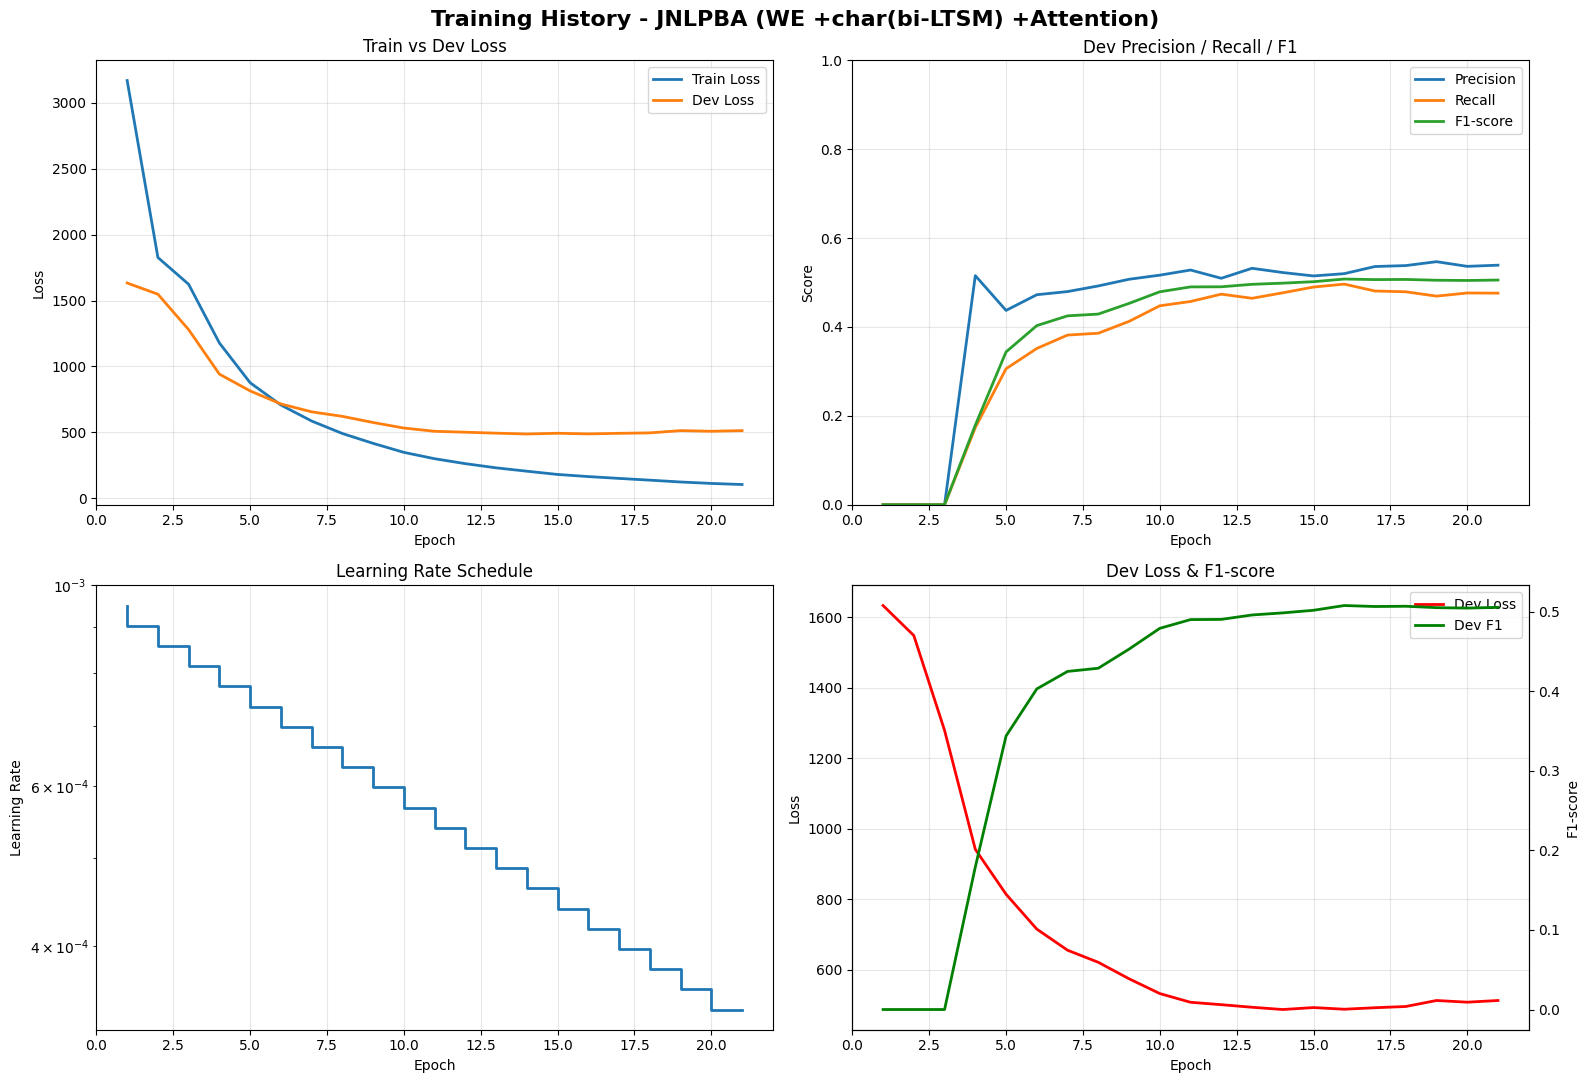


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM) +Attention)
Meilleur F1 (dev)       : 0.5078
Meilleure Precision(dev): 0.5469
Meilleur Recall (dev)   : 0.4964
Final train loss        : 103.3083
Final dev loss          : 512.3552
Final learning rate     : 0.000341


In [30]:
plot_training_history(history_we_char_attention, dataset_name="JNLPBA (WE +char(bi-LTSM) +Attention)")

In [31]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_attention/best_model.pt"
model_we_char_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_ncbi['test_loader']
predictions_we_char_attention, targets_we_char_attention = predict_on_test_set(
    model=model_we_char_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_attention/best_model.pt
Best F1 enregistré: 0.5078
Époque: 15
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O         


Accuracy globale: 0.9767

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'I-Disease', 'O', 'B-Disease'}
  Unique entity tags in predictions: {'I-Disease', 'O', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


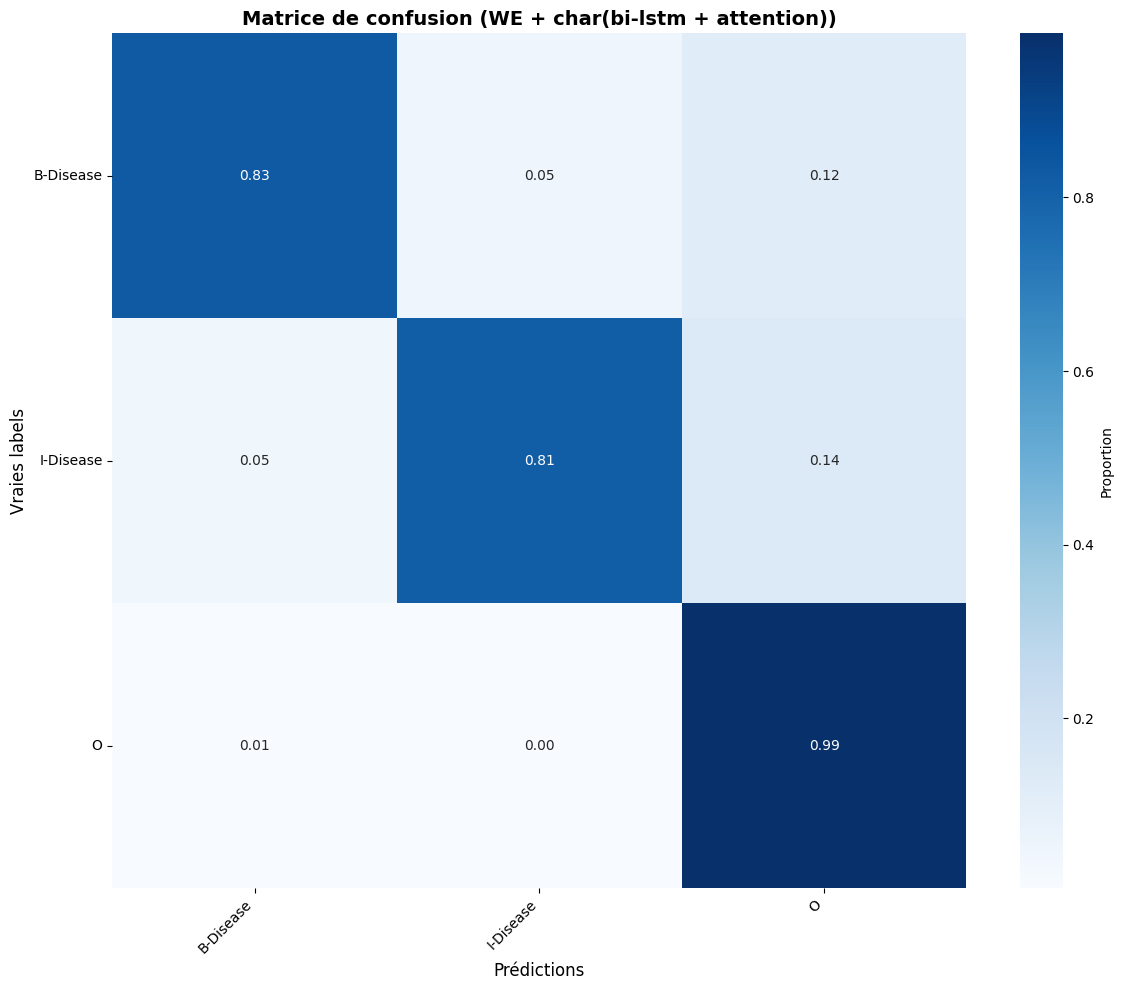

              precision    recall  f1-score   support

   B-Disease       0.78      0.83      0.80       720
   I-Disease       0.85      0.81      0.83       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.87      0.88      0.87     21017
weighted avg       0.98      0.98      0.98     21017



In [32]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_attention, predictions_we_char_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char_attention) == set(targets_we_char_attention) or all(isinstance(p, str) for p in predictions_we_char_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_attention,
        targets=targets_we_char_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm + attention))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_attention[:10])}")

## Combinaison 5:  WE + char(cnn)

In [41]:
model_we_char_cnn, history_we_char_cnn = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,354,080


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 01/40 | Train loss: 3267.8123 | Dev loss: 1860.9181 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:04<00:00,  3.88it/s]


Epoch 02/40 | Train loss: 1855.6678 | Dev loss: 1567.5087 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 03/40 | Train loss: 1703.9770 | Dev loss: 1455.7100 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 04/40 | Train loss: 1520.2742 | Dev loss: 1247.9160 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000815


Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 05/40 | Train loss: 1241.7943 | Dev loss: 983.0697 | P: 0.3118 R: 0.0225 F1: 0.0419 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.0419 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]


Epoch 06/40 | Train loss: 968.8363 | Dev loss: 798.9134 | P: 0.5134 R: 0.1585 F1: 0.2206 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.2206 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]


Epoch 07/40 | Train loss: 769.8273 | Dev loss: 696.9754 | P: 0.5145 R: 0.2710 F1: 0.3471 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.3471 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


Epoch 08/40 | Train loss: 648.4319 | Dev loss: 623.9072 | P: 0.4926 R: 0.3888 F1: 0.4272 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4272 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s]


Epoch 09/40 | Train loss: 561.7425 | Dev loss: 574.3146 | P: 0.5214 R: 0.4057 F1: 0.4540 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4540 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 10/40 | Train loss: 493.1200 | Dev loss: 536.1427 | P: 0.5245 R: 0.4395 F1: 0.4770 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4770 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.85it/s]


Epoch 11/40 | Train loss: 441.1623 | Dev loss: 529.8349 | P: 0.4913 R: 0.4818 F1: 0.4858 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4858 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.92it/s]


Epoch 12/40 | Train loss: 404.6398 | Dev loss: 487.4755 | P: 0.5376 R: 0.4581 F1: 0.4943 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4943 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]


Epoch 13/40 | Train loss: 373.7386 | Dev loss: 470.6529 | P: 0.5478 R: 0.4703 F1: 0.5061 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.5061 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 14/40 | Train loss: 345.1247 | Dev loss: 464.7330 | P: 0.5197 R: 0.5014 F1: 0.5101 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.5101 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]


Epoch 15/40 | Train loss: 318.4178 | Dev loss: 442.9952 | P: 0.5318 R: 0.4999 F1: 0.5152 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.5152 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.42it/s]


Epoch 16/40 | Train loss: 299.6716 | Dev loss: 441.0414 | P: 0.5393 R: 0.5005 F1: 0.5191 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.5191 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]


Epoch 17/40 | Train loss: 281.9091 | Dev loss: 431.4138 | P: 0.5397 R: 0.5063 F1: 0.5224 | LR: 0.000418
Meilleur modèle sauvegardé: F1 0.5224 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]


Epoch 18/40 | Train loss: 267.4228 | Dev loss: 422.3922 | P: 0.5441 R: 0.5091 F1: 0.5260 | LR: 0.000397
Meilleur modèle sauvegardé: F1 0.5260 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


Epoch 19/40 | Train loss: 254.5806 | Dev loss: 424.4545 | P: 0.5385 R: 0.5088 F1: 0.5233 | LR: 0.000377


Training: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


Epoch 20/40 | Train loss: 241.4720 | Dev loss: 413.9339 | P: 0.5479 R: 0.5085 F1: 0.5274 | LR: 0.000358
Meilleur modèle sauvegardé: F1 0.5274 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


Epoch 21/40 | Train loss: 234.0013 | Dev loss: 412.0757 | P: 0.5533 R: 0.5059 F1: 0.5285 | LR: 0.000341
Meilleur modèle sauvegardé: F1 0.5285 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 22/40 | Train loss: 221.8554 | Dev loss: 405.3080 | P: 0.5533 R: 0.5117 F1: 0.5317 | LR: 0.000324
Meilleur modèle sauvegardé: F1 0.5317 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


Epoch 23/40 | Train loss: 215.6627 | Dev loss: 411.8491 | P: 0.5467 R: 0.5134 F1: 0.5295 | LR: 0.000307


Training: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]


Epoch 24/40 | Train loss: 207.9587 | Dev loss: 407.3188 | P: 0.5559 R: 0.5088 F1: 0.5313 | LR: 0.000292


Training: 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]


Epoch 25/40 | Train loss: 200.7735 | Dev loss: 411.1340 | P: 0.5681 R: 0.5038 F1: 0.5337 | LR: 0.000277
Meilleur modèle sauvegardé: F1 0.5337 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]


Epoch 26/40 | Train loss: 193.0832 | Dev loss: 410.0171 | P: 0.5645 R: 0.5117 F1: 0.5368 | LR: 0.000264
Meilleur modèle sauvegardé: F1 0.5368 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]


Epoch 27/40 | Train loss: 186.0410 | Dev loss: 411.3636 | P: 0.5662 R: 0.5070 F1: 0.5347 | LR: 0.000250


Training: 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 28/40 | Train loss: 182.1402 | Dev loss: 407.1566 | P: 0.5609 R: 0.5155 F1: 0.5372 | LR: 0.000238
Meilleur modèle sauvegardé: F1 0.5372 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.92it/s]


Epoch 29/40 | Train loss: 176.1589 | Dev loss: 408.2492 | P: 0.5599 R: 0.5176 F1: 0.5379 | LR: 0.000226
Meilleur modèle sauvegardé: F1 0.5379 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Epoch 30/40 | Train loss: 173.2161 | Dev loss: 404.6047 | P: 0.5626 R: 0.5162 F1: 0.5384 | LR: 0.000215
Meilleur modèle sauvegardé: F1 0.5384 (./checkpoints/NCBI/WE_char_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  4.23it/s]


Epoch 31/40 | Train loss: 170.1507 | Dev loss: 405.5704 | P: 0.5631 R: 0.5148 F1: 0.5378 | LR: 0.000204


Training: 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]


Epoch 32/40 | Train loss: 164.1638 | Dev loss: 404.1729 | P: 0.5591 R: 0.5172 F1: 0.5374 | LR: 0.000194


Training: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]


Epoch 33/40 | Train loss: 160.4966 | Dev loss: 405.1851 | P: 0.5641 R: 0.5148 F1: 0.5383 | LR: 0.000184


Training: 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]


Epoch 34/40 | Train loss: 159.0825 | Dev loss: 404.4296 | P: 0.5625 R: 0.5126 F1: 0.5364 | LR: 0.000175


Training: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 35/40 | Train loss: 151.5469 | Dev loss: 407.2105 | P: 0.5486 R: 0.5221 F1: 0.5350 | LR: 0.000166


Training: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s]


Epoch 36/40 | Train loss: 151.7701 | Dev loss: 404.6049 | P: 0.5529 R: 0.5195 F1: 0.5357 | LR: 0.000158
Early stopping triggered après 36 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 346.2275
Precision: 0.5766
Recall: 0.5536
F1-score: 0.5648


In [42]:
print_model_layers(model_we_char_cnn)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      185,344
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,354,080


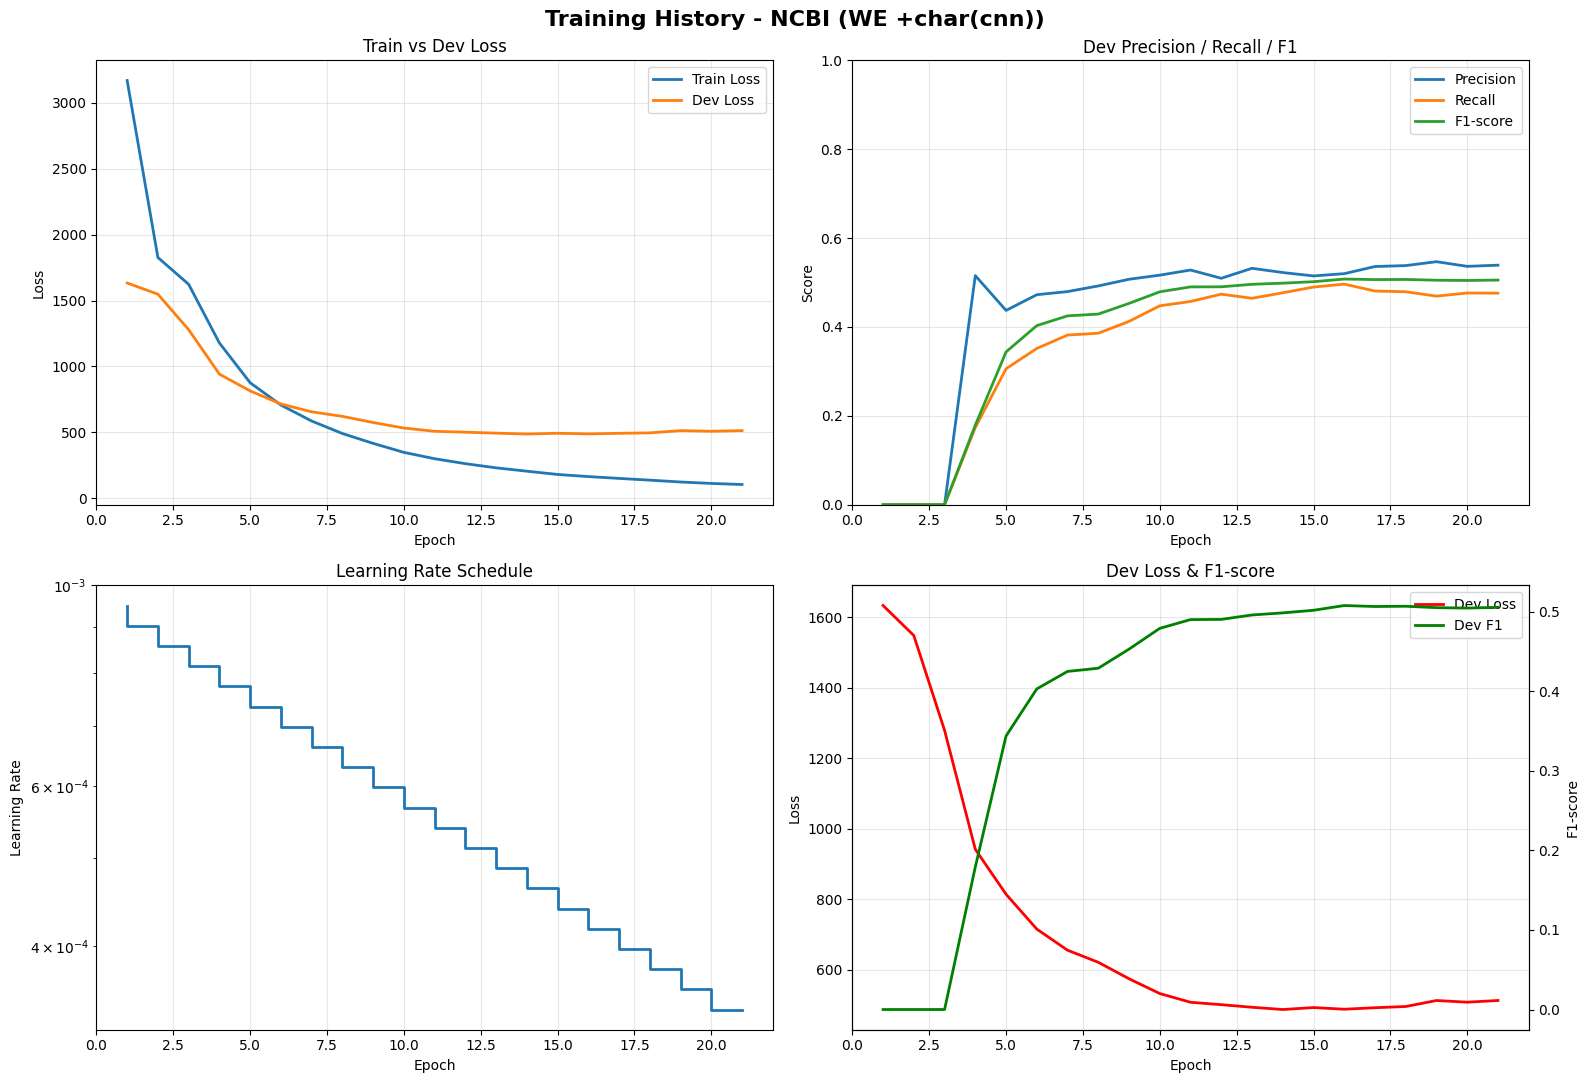


STATISTIQUES FINALES - NCBI (WE +char(cnn))
Meilleur F1 (dev)       : 0.5078
Meilleure Precision(dev): 0.5469
Meilleur Recall (dev)   : 0.4964
Final train loss        : 103.3083
Final dev loss          : 512.3552
Final learning rate     : 0.000341


In [43]:
plot_training_history(history_we_char_attention, dataset_name="NCBI (WE +char(cnn))")

In [15]:
model_path = "./checkpoints/NCBI/WE_char_cnn/best_model.pt"
model_we_char_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)

test_loader = results_ncbi['test_loader']
predictions_we_char_cnn, targets_we_char_cnn = predict_on_test_set(
    model=model_we_char_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_cnn/best_model.pt
Best F1 enregistré: 0.5384
Époque: 29
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
torch.Size([32, 200])
torch.Size([32, 200, 20])
torch.Size([32, 200])
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disea


Accuracy globale: 0.9811

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'I-Disease', 'B-Disease', 'O'}
  Unique entity tags in predictions: {'I-Disease', 'B-Disease', 'O'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


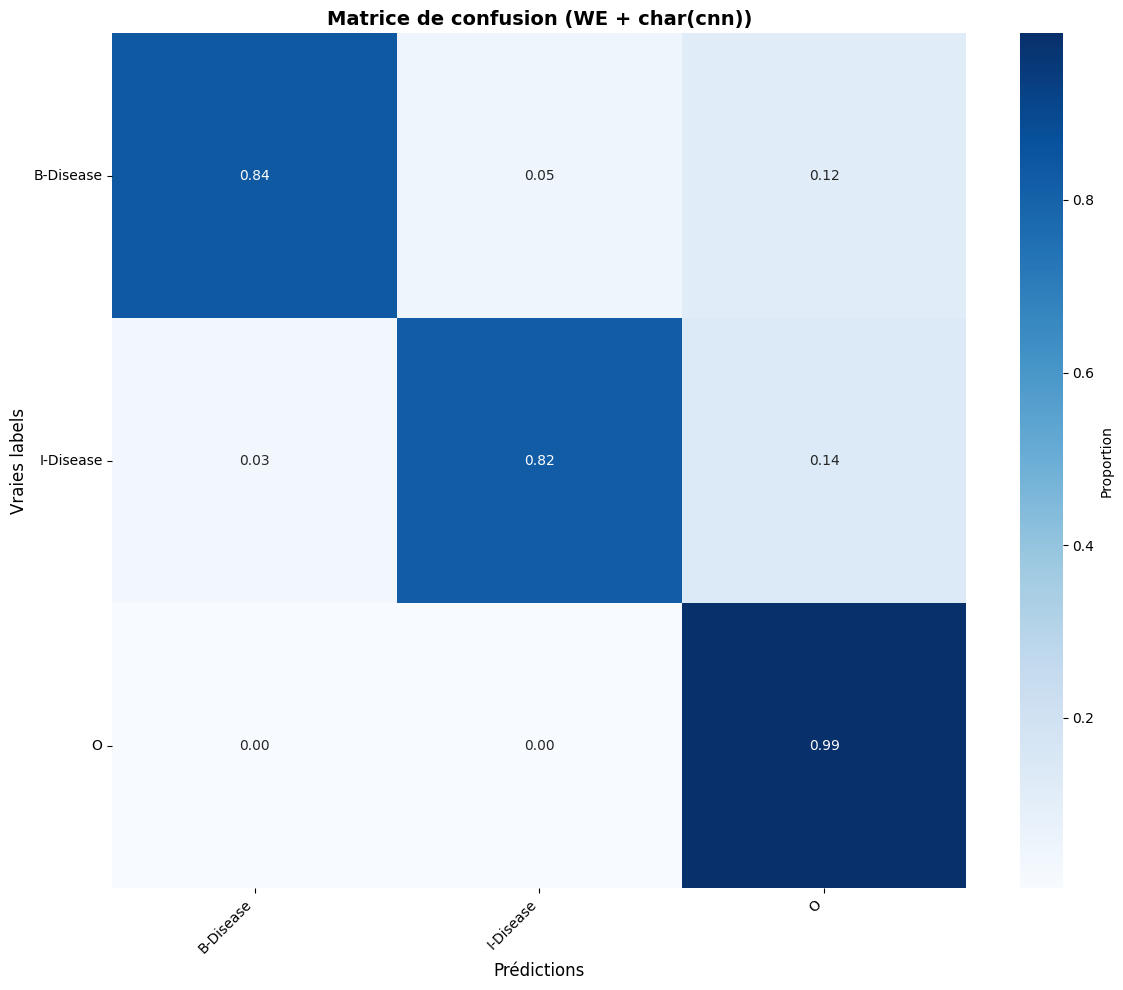

              precision    recall  f1-score   support

   B-Disease       0.85      0.84      0.84       720
   I-Disease       0.88      0.82      0.85       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.91      0.88      0.90     21017
weighted avg       0.98      0.98      0.98     21017



In [ ]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn, predictions_we_char_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char_cnn) == set(targets_we_char_cnn) or all(isinstance(p, str) for p in predictions_we_char_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn,
        targets=targets_we_char_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn[:10])}")

## Combinaison 6:  WE + char(cnn) + attention

In [48]:
model_we_char_cnn_attention, history_we_char_cnn_attention = run_pipeline(
     dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=5,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 1,387,104


Training: 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


Epoch 01/40 | Train loss: 3113.4679 | Dev loss: 1603.8729 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]


Epoch 02/40 | Train loss: 1827.1722 | Dev loss: 1566.1432 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:06<00:00,  2.74it/s]


Epoch 03/40 | Train loss: 1672.8540 | Dev loss: 1416.4670 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Epoch 04/40 | Train loss: 1422.4166 | Dev loss: 1055.4737 | P: 0.2712 R: 0.0372 F1: 0.0654 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.0654 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


Epoch 05/40 | Train loss: 1010.9039 | Dev loss: 803.8811 | P: 0.4368 R: 0.2410 F1: 0.2720 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.2720 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]


Epoch 06/40 | Train loss: 776.7198 | Dev loss: 740.7042 | P: 0.4722 R: 0.3234 F1: 0.3824 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.3824 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.66it/s]


Epoch 07/40 | Train loss: 656.4522 | Dev loss: 651.8264 | P: 0.4723 R: 0.3793 F1: 0.4195 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4195 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Epoch 08/40 | Train loss: 567.4927 | Dev loss: 618.2837 | P: 0.4635 R: 0.4324 F1: 0.4461 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4461 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]


Epoch 09/40 | Train loss: 497.2912 | Dev loss: 586.5988 | P: 0.4979 R: 0.4313 F1: 0.4622 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4622 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


Epoch 10/40 | Train loss: 437.0784 | Dev loss: 548.4167 | P: 0.5156 R: 0.4387 F1: 0.4734 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4734 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Epoch 11/40 | Train loss: 390.4403 | Dev loss: 530.8129 | P: 0.4943 R: 0.4858 F1: 0.4893 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4893 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Epoch 12/40 | Train loss: 351.6184 | Dev loss: 510.9472 | P: 0.5216 R: 0.4832 F1: 0.5015 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.5015 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]


Epoch 13/40 | Train loss: 320.3374 | Dev loss: 502.5395 | P: 0.5226 R: 0.4919 F1: 0.5065 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.5065 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


Epoch 14/40 | Train loss: 294.3756 | Dev loss: 496.5975 | P: 0.5366 R: 0.4833 F1: 0.5083 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.5083 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]


Epoch 15/40 | Train loss: 270.8601 | Dev loss: 478.3683 | P: 0.5291 R: 0.4999 F1: 0.5138 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.5138 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Epoch 16/40 | Train loss: 248.7318 | Dev loss: 470.7475 | P: 0.5305 R: 0.5091 F1: 0.5195 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.5195 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]


Epoch 17/40 | Train loss: 232.2037 | Dev loss: 476.2245 | P: 0.5154 R: 0.5159 F1: 0.5156 | LR: 0.000418


Training: 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]


Epoch 18/40 | Train loss: 218.3614 | Dev loss: 464.9199 | P: 0.5223 R: 0.5140 F1: 0.5181 | LR: 0.000397


Training: 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]


Epoch 19/40 | Train loss: 202.0891 | Dev loss: 466.6088 | P: 0.5317 R: 0.5147 F1: 0.5227 | LR: 0.000377
Meilleur modèle sauvegardé: F1 0.5227 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]


Epoch 20/40 | Train loss: 189.3803 | Dev loss: 468.8051 | P: 0.5271 R: 0.5163 F1: 0.5216 | LR: 0.000358


Training: 100%|██████████| 18/18 [00:06<00:00,  2.86it/s]


Epoch 21/40 | Train loss: 177.2720 | Dev loss: 472.1386 | P: 0.5323 R: 0.5146 F1: 0.5233 | LR: 0.000341
Meilleur modèle sauvegardé: F1 0.5233 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Epoch 22/40 | Train loss: 168.9712 | Dev loss: 466.6766 | P: 0.5372 R: 0.5178 F1: 0.5273 | LR: 0.000324
Meilleur modèle sauvegardé: F1 0.5273 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]


Epoch 23/40 | Train loss: 158.0542 | Dev loss: 468.4330 | P: 0.5386 R: 0.5167 F1: 0.5273 | LR: 0.000307


Training: 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]


Epoch 24/40 | Train loss: 149.1838 | Dev loss: 473.2944 | P: 0.5216 R: 0.5273 F1: 0.5243 | LR: 0.000292


Training: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]


Epoch 25/40 | Train loss: 141.3284 | Dev loss: 474.3666 | P: 0.5481 R: 0.5126 F1: 0.5297 | LR: 0.000277
Meilleur modèle sauvegardé: F1 0.5297 (./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]


Epoch 26/40 | Train loss: 134.9823 | Dev loss: 476.6924 | P: 0.5374 R: 0.5176 F1: 0.5273 | LR: 0.000264


Training: 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]


Epoch 27/40 | Train loss: 130.0228 | Dev loss: 478.4439 | P: 0.5455 R: 0.5100 F1: 0.5271 | LR: 0.000250


Training: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]


Epoch 28/40 | Train loss: 124.5331 | Dev loss: 482.4452 | P: 0.5414 R: 0.5145 F1: 0.5276 | LR: 0.000238


Training: 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Epoch 29/40 | Train loss: 117.2662 | Dev loss: 481.4491 | P: 0.5408 R: 0.5168 F1: 0.5285 | LR: 0.000226


Training: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Epoch 30/40 | Train loss: 115.8090 | Dev loss: 493.5036 | P: 0.5235 R: 0.5286 F1: 0.5257 | LR: 0.000215
Early stopping triggered après 30 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 368.6103
Precision: 0.5697
Recall: 0.5537
F1-score: 0.5615


In [49]:
print_model_layers(model_we_char_cnn_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      185,344
attention_layer.W (Linear)     |          128
attention_projection (Linear)  |       32,896
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,387,104


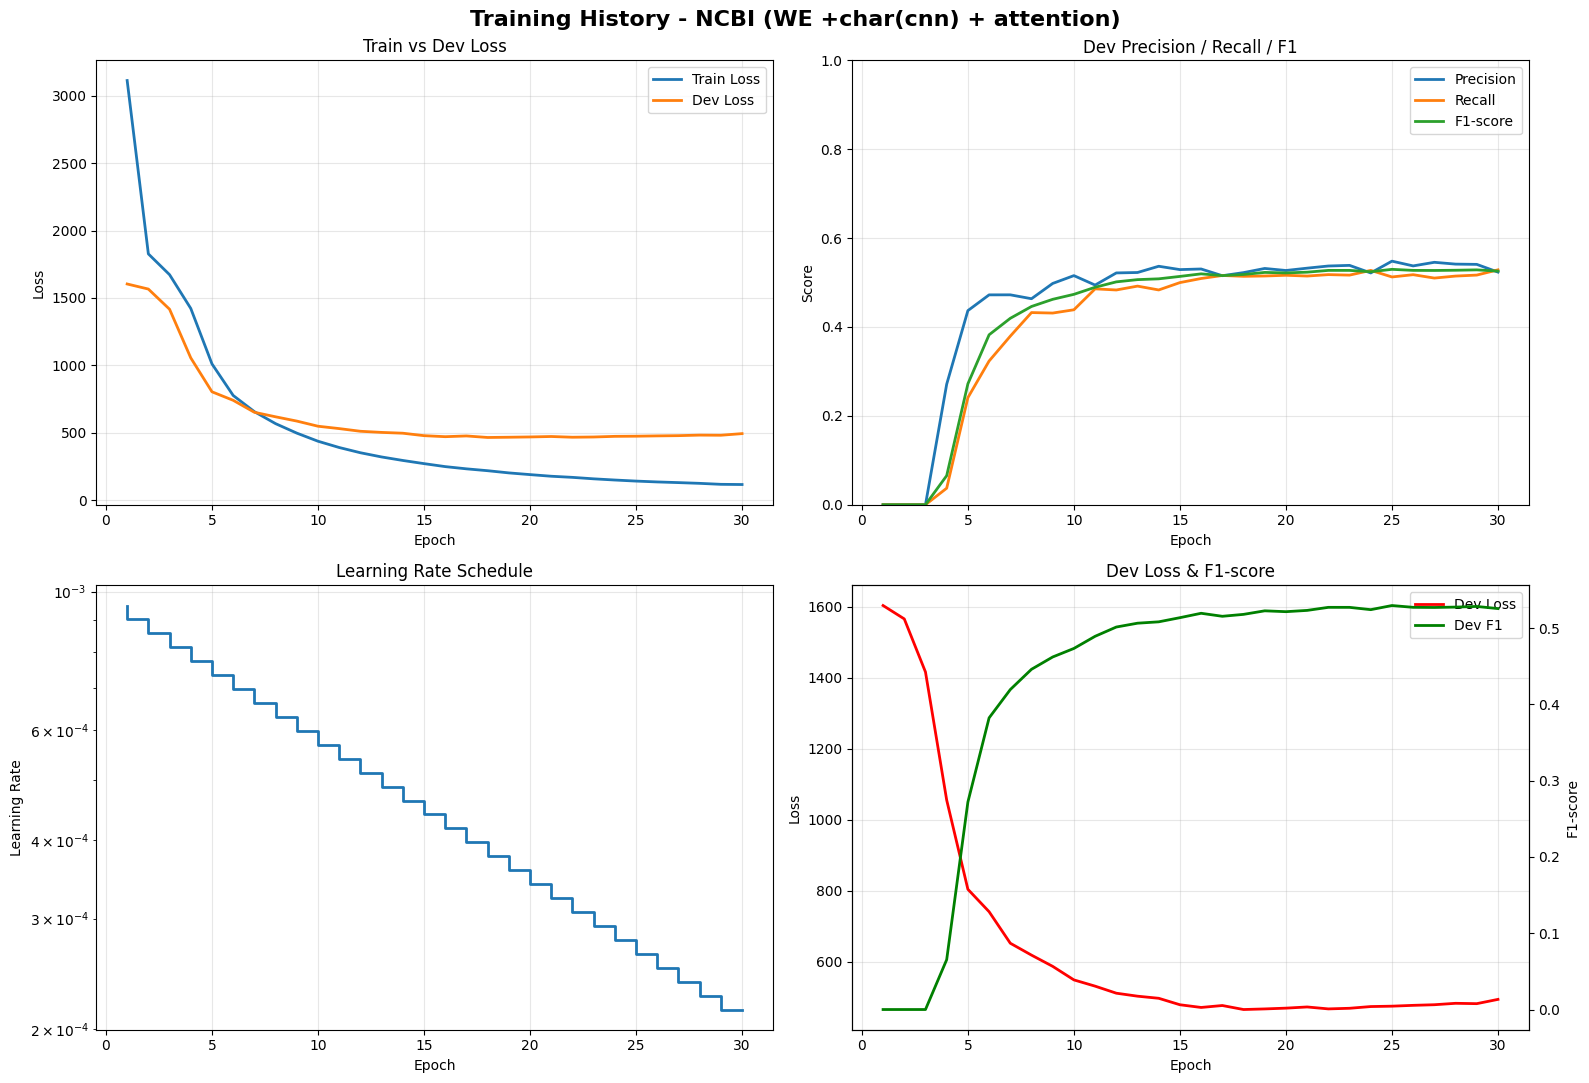


STATISTIQUES FINALES - NCBI (WE +char(cnn) + attention)
Meilleur F1 (dev)       : 0.5297
Meilleure Precision(dev): 0.5481
Meilleur Recall (dev)   : 0.5286
Final train loss        : 115.8090
Final dev loss          : 493.5036
Final learning rate     : 0.000215


In [50]:
plot_training_history(history_we_char_cnn_attention, dataset_name="NCBI (WE +char(cnn) + attention)")

In [20]:
model_path = "./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt"
model_we_char_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)
test_loader = results_ncbi['test_loader']
predictions_we_char_cnn_attention, targets_we_char_cnn_attention = predict_on_test_set(
    model=model_we_char_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt
Best F1 enregistré: 0.5297
Époque: 24
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
torch.Size([32, 200])
torch.Size([32, 200, 20])
torch.Size([32, 200])
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14


Accuracy globale: 0.9805

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'I-Disease', 'B-Disease', 'O'}
  Unique entity tags in predictions: {'I-Disease', 'B-Disease', 'O'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


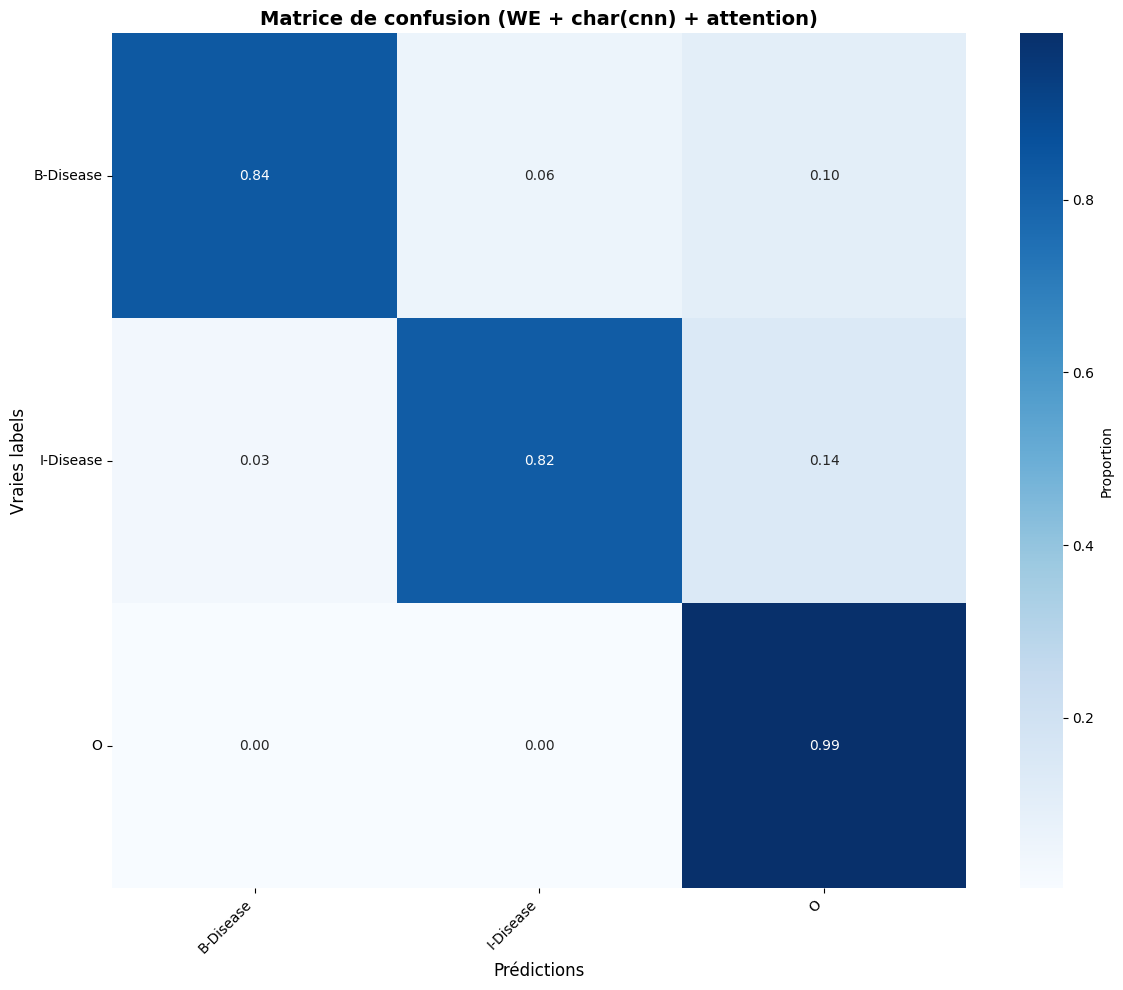

              precision    recall  f1-score   support

   B-Disease       0.84      0.84      0.84       720
   I-Disease       0.87      0.82      0.85       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.90      0.88      0.89     21017
weighted avg       0.98      0.98      0.98     21017



In [21]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn_attention, predictions_we_char_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']

if set(predictions_we_char_cnn_attention) == set(targets_we_char_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn_attention,
        targets=targets_we_char_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn) + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn_attention[:10])}")

## Combinaison 7: WE + char(cnn, bilstm)

In [14]:
model_we_char_cnn_bilstm, history_we_char_cnn_bilstm = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=6,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,450,380


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:05<00:00,  3.24it/s]


Epoch 01/40 | Train loss: 2773.1225 | Dev loss: 1725.3391 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 02/40 | Train loss: 1805.1843 | Dev loss: 1524.5359 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:05<00:00,  3.35it/s]


Epoch 03/40 | Train loss: 1646.5070 | Dev loss: 1378.7176 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 04/40 | Train loss: 1432.1856 | Dev loss: 1143.5283 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000815


Training: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 05/40 | Train loss: 1136.8187 | Dev loss: 935.9319 | P: 0.5831 R: 0.0350 F1: 0.0642 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.0642 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Epoch 06/40 | Train loss: 890.7668 | Dev loss: 766.0900 | P: 0.4890 R: 0.3093 F1: 0.3761 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.3761 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]


Epoch 07/40 | Train loss: 723.7786 | Dev loss: 671.6178 | P: 0.5159 R: 0.3346 F1: 0.4049 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4049 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


Epoch 08/40 | Train loss: 614.5530 | Dev loss: 612.8732 | P: 0.5047 R: 0.4165 F1: 0.4564 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4564 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Epoch 09/40 | Train loss: 536.1856 | Dev loss: 571.2549 | P: 0.5353 R: 0.4030 F1: 0.4598 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4598 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Epoch 10/40 | Train loss: 477.2944 | Dev loss: 532.3100 | P: 0.5173 R: 0.4422 F1: 0.4767 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4767 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Epoch 11/40 | Train loss: 431.2930 | Dev loss: 504.6681 | P: 0.5234 R: 0.4531 F1: 0.4857 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4857 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


Epoch 12/40 | Train loss: 389.7612 | Dev loss: 487.9439 | P: 0.5385 R: 0.4476 F1: 0.4889 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4889 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 13/40 | Train loss: 355.9924 | Dev loss: 469.0330 | P: 0.5396 R: 0.4688 F1: 0.5017 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.5017 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


Epoch 14/40 | Train loss: 329.7812 | Dev loss: 456.2333 | P: 0.5308 R: 0.4909 F1: 0.5100 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.5100 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Epoch 15/40 | Train loss: 308.3248 | Dev loss: 448.8794 | P: 0.5471 R: 0.4764 F1: 0.5092 | LR: 0.000463


Training: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Epoch 16/40 | Train loss: 284.7495 | Dev loss: 449.2273 | P: 0.5203 R: 0.5075 F1: 0.5138 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.5138 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s]


Epoch 17/40 | Train loss: 270.7874 | Dev loss: 441.5035 | P: 0.5585 R: 0.4779 F1: 0.5151 | LR: 0.000418
Meilleur modèle sauvegardé: F1 0.5151 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 18/40 | Train loss: 255.5874 | Dev loss: 434.0313 | P: 0.5319 R: 0.4966 F1: 0.5136 | LR: 0.000397


Training: 100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


Epoch 19/40 | Train loss: 239.1030 | Dev loss: 426.8110 | P: 0.5502 R: 0.4927 F1: 0.5197 | LR: 0.000377
Meilleur modèle sauvegardé: F1 0.5197 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 20/40 | Train loss: 226.0352 | Dev loss: 425.1450 | P: 0.5457 R: 0.4908 F1: 0.5168 | LR: 0.000358


Training: 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


Epoch 21/40 | Train loss: 215.0049 | Dev loss: 431.6048 | P: 0.5517 R: 0.4859 F1: 0.5165 | LR: 0.000341


Training: 100%|██████████| 18/18 [00:05<00:00,  3.40it/s]


Epoch 22/40 | Train loss: 209.1073 | Dev loss: 421.8007 | P: 0.5384 R: 0.4994 F1: 0.5182 | LR: 0.000324


Training: 100%|██████████| 18/18 [00:05<00:00,  3.34it/s]


Epoch 23/40 | Train loss: 198.7322 | Dev loss: 417.9072 | P: 0.5451 R: 0.4973 F1: 0.5201 | LR: 0.000307
Meilleur modèle sauvegardé: F1 0.5201 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Epoch 24/40 | Train loss: 191.3796 | Dev loss: 418.1380 | P: 0.5477 R: 0.4973 F1: 0.5210 | LR: 0.000292
Meilleur modèle sauvegardé: F1 0.5210 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 25/40 | Train loss: 184.8715 | Dev loss: 417.9439 | P: 0.5417 R: 0.5072 F1: 0.5239 | LR: 0.000277
Meilleur modèle sauvegardé: F1 0.5239 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 26/40 | Train loss: 176.7320 | Dev loss: 425.7100 | P: 0.5354 R: 0.5207 F1: 0.5280 | LR: 0.000264
Meilleur modèle sauvegardé: F1 0.5280 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 27/40 | Train loss: 171.3532 | Dev loss: 415.3272 | P: 0.5514 R: 0.5054 F1: 0.5274 | LR: 0.000250


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 28/40 | Train loss: 166.3768 | Dev loss: 412.9081 | P: 0.5534 R: 0.5112 F1: 0.5315 | LR: 0.000238
Meilleur modèle sauvegardé: F1 0.5315 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Epoch 29/40 | Train loss: 162.2922 | Dev loss: 429.0934 | P: 0.5390 R: 0.5242 F1: 0.5314 | LR: 0.000226


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 30/40 | Train loss: 156.0267 | Dev loss: 424.1706 | P: 0.5490 R: 0.5135 F1: 0.5306 | LR: 0.000215


Training: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Epoch 31/40 | Train loss: 151.9192 | Dev loss: 418.5899 | P: 0.5607 R: 0.5032 F1: 0.5304 | LR: 0.000204


Training: 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


Epoch 32/40 | Train loss: 147.5624 | Dev loss: 425.2462 | P: 0.5528 R: 0.5201 F1: 0.5359 | LR: 0.000194
Meilleur modèle sauvegardé: F1 0.5359 (./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 33/40 | Train loss: 142.1750 | Dev loss: 429.6499 | P: 0.5458 R: 0.5195 F1: 0.5323 | LR: 0.000184


Training: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 34/40 | Train loss: 138.8883 | Dev loss: 437.9900 | P: 0.5358 R: 0.5308 F1: 0.5332 | LR: 0.000175


Training: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Epoch 35/40 | Train loss: 139.0152 | Dev loss: 435.2066 | P: 0.5479 R: 0.5160 F1: 0.5315 | LR: 0.000166


Training: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]


Epoch 36/40 | Train loss: 133.8889 | Dev loss: 432.3746 | P: 0.5453 R: 0.5240 F1: 0.5343 | LR: 0.000158


Training: 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


Epoch 37/40 | Train loss: 131.2343 | Dev loss: 440.4837 | P: 0.5464 R: 0.5199 F1: 0.5328 | LR: 0.000150


Training: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 38/40 | Train loss: 131.2452 | Dev loss: 429.4014 | P: 0.5500 R: 0.5154 F1: 0.5322 | LR: 0.000142
Early stopping triggered après 38 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 342.3765
Precision: 0.5746
Recall: 0.5545
F1-score: 0.5643


In [15]:
print_model_layers(model_we_char_cnn_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      236,544
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,450,380


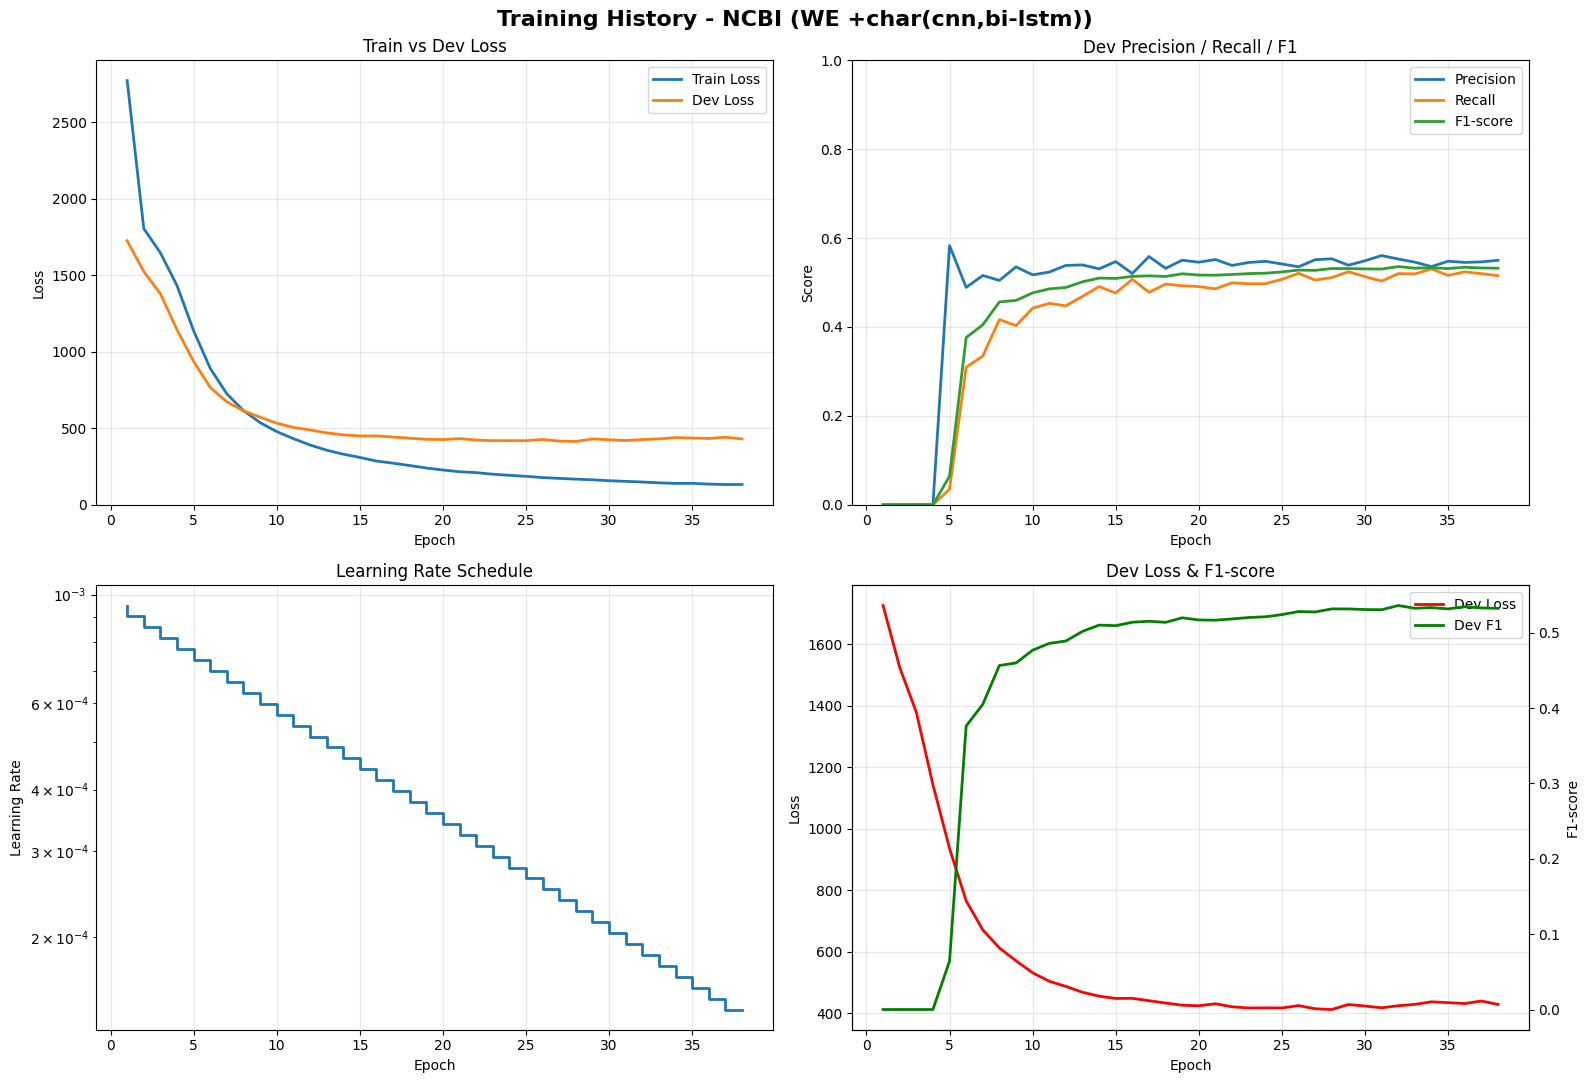


STATISTIQUES FINALES - NCBI (WE +char(cnn,bi-lstm))
Meilleur F1 (dev)       : 0.5359
Meilleure Precision(dev): 0.5831
Meilleur Recall (dev)   : 0.5308
Final train loss        : 131.2452
Final dev loss          : 429.4014
Final learning rate     : 0.000142


In [16]:
plot_training_history(history_we_char_cnn_bilstm, dataset_name="NCBI (WE +char(cnn,bi-lstm))")

In [17]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt"
model_we_char__bilstm_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn = predict_on_test_set(
    model=model_we_char__bilstm_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt
Best F1 enregistré: 0.5359
Époque: 31
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O               


Accuracy globale: 0.9809

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'O', 'I-Disease', 'B-Disease'}
  Unique entity tags in predictions: {'O', 'I-Disease', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


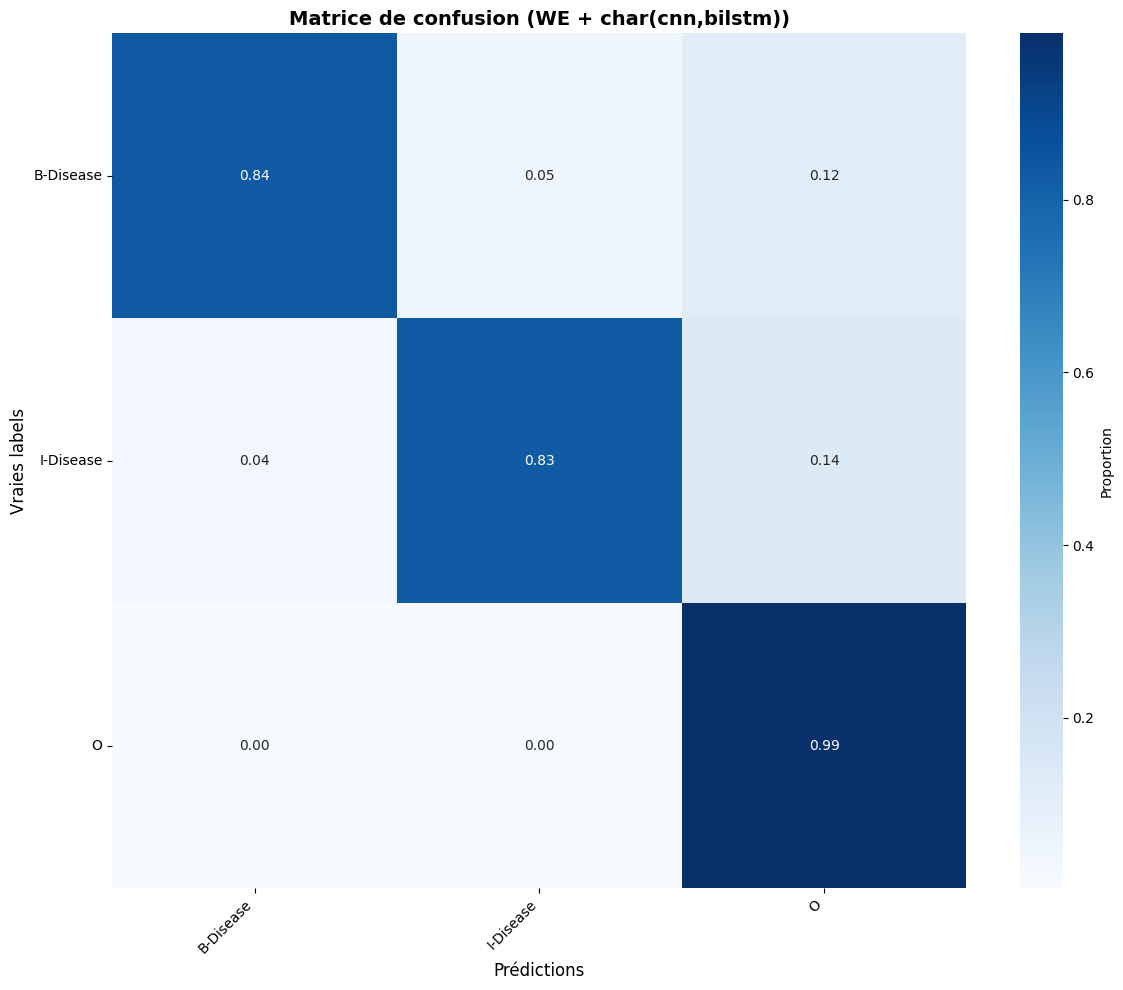

              precision    recall  f1-score   support

   B-Disease       0.84      0.84      0.84       720
   I-Disease       0.88      0.83      0.85       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.90      0.89      0.89     21017
weighted avg       0.98      0.98      0.98     21017



In [18]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn, predictions_we_char__bilstm_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char__bilstm_cnn) == set(targets_we_char__bilstm_cnn) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn,
        targets=targets_we_char__bilstm_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn[:10])}")

## Combinaison 8: WE + char(cnn, bilstm) + attention

In [19]:
model_we_char_cnn_bilstm_attention, history_we_char_cnn_bilstm_attention = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 1,483,404


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


Epoch 01/40 | Train loss: 3064.3320 | Dev loss: 1679.0603 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


Epoch 02/40 | Train loss: 1867.2956 | Dev loss: 1579.9483 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


Epoch 03/40 | Train loss: 1732.8124 | Dev loss: 1427.3365 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


Epoch 04/40 | Train loss: 1402.0737 | Dev loss: 1040.7169 | P: 0.2397 R: 0.0902 F1: 0.1311 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.1311 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


Epoch 05/40 | Train loss: 957.1194 | Dev loss: 836.9798 | P: 0.3672 R: 0.2593 F1: 0.2639 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.2639 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


Epoch 06/40 | Train loss: 761.3737 | Dev loss: 750.1389 | P: 0.4604 R: 0.3425 F1: 0.3907 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.3907 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


Epoch 07/40 | Train loss: 652.2031 | Dev loss: 676.0268 | P: 0.4353 R: 0.4381 F1: 0.4366 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4366 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


Epoch 08/40 | Train loss: 553.6216 | Dev loss: 620.8361 | P: 0.4536 R: 0.4641 F1: 0.4588 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4588 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


Epoch 09/40 | Train loss: 473.8263 | Dev loss: 576.1666 | P: 0.4978 R: 0.4521 F1: 0.4738 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4738 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


Epoch 10/40 | Train loss: 418.4043 | Dev loss: 576.8363 | P: 0.5342 R: 0.4366 F1: 0.4796 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4796 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


Epoch 11/40 | Train loss: 376.1713 | Dev loss: 516.5503 | P: 0.5078 R: 0.4997 F1: 0.5037 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.5037 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


Epoch 12/40 | Train loss: 348.4774 | Dev loss: 507.9873 | P: 0.5072 R: 0.5062 F1: 0.5059 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.5059 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


Epoch 13/40 | Train loss: 312.9488 | Dev loss: 516.2323 | P: 0.5206 R: 0.4807 F1: 0.4991 | LR: 0.000513


Training: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


Epoch 14/40 | Train loss: 285.1825 | Dev loss: 498.6458 | P: 0.5448 R: 0.4901 F1: 0.5155 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.5155 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


Epoch 15/40 | Train loss: 262.2099 | Dev loss: 477.6188 | P: 0.5203 R: 0.5128 F1: 0.5164 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.5164 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]


Epoch 16/40 | Train loss: 242.7280 | Dev loss: 466.3836 | P: 0.5520 R: 0.5100 F1: 0.5301 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.5301 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch 17/40 | Train loss: 231.1484 | Dev loss: 471.4180 | P: 0.5338 R: 0.5097 F1: 0.5212 | LR: 0.000418


Training: 100%|██████████| 18/18 [00:10<00:00,  1.80it/s]


Epoch 18/40 | Train loss: 215.8718 | Dev loss: 480.4217 | P: 0.5397 R: 0.5021 F1: 0.5198 | LR: 0.000397


Training: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


Epoch 19/40 | Train loss: 202.4273 | Dev loss: 460.1405 | P: 0.5437 R: 0.5139 F1: 0.5281 | LR: 0.000377


Training: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


Epoch 20/40 | Train loss: 192.2097 | Dev loss: 457.9455 | P: 0.5443 R: 0.5188 F1: 0.5311 | LR: 0.000358
Meilleur modèle sauvegardé: F1 0.5311 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]


Epoch 21/40 | Train loss: 179.2606 | Dev loss: 464.7375 | P: 0.5409 R: 0.5183 F1: 0.5294 | LR: 0.000341


Training: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch 22/40 | Train loss: 172.8557 | Dev loss: 463.9893 | P: 0.5267 R: 0.5274 F1: 0.5271 | LR: 0.000324


Training: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


Epoch 23/40 | Train loss: 167.2989 | Dev loss: 461.3961 | P: 0.5347 R: 0.5246 F1: 0.5295 | LR: 0.000307


Training: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


Epoch 24/40 | Train loss: 158.4768 | Dev loss: 466.4944 | P: 0.5385 R: 0.5185 F1: 0.5283 | LR: 0.000292
Early stopping triggered après 24 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 382.4024
Precision: 0.5488
Recall: 0.5643
F1-score: 0.5558


In [20]:
print_model_layers(model_we_char_cnn_bilstm_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      236,544
attention_layer.W (Linear)     |          128
attention_projection (Linear)  |       32,896
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,483,404


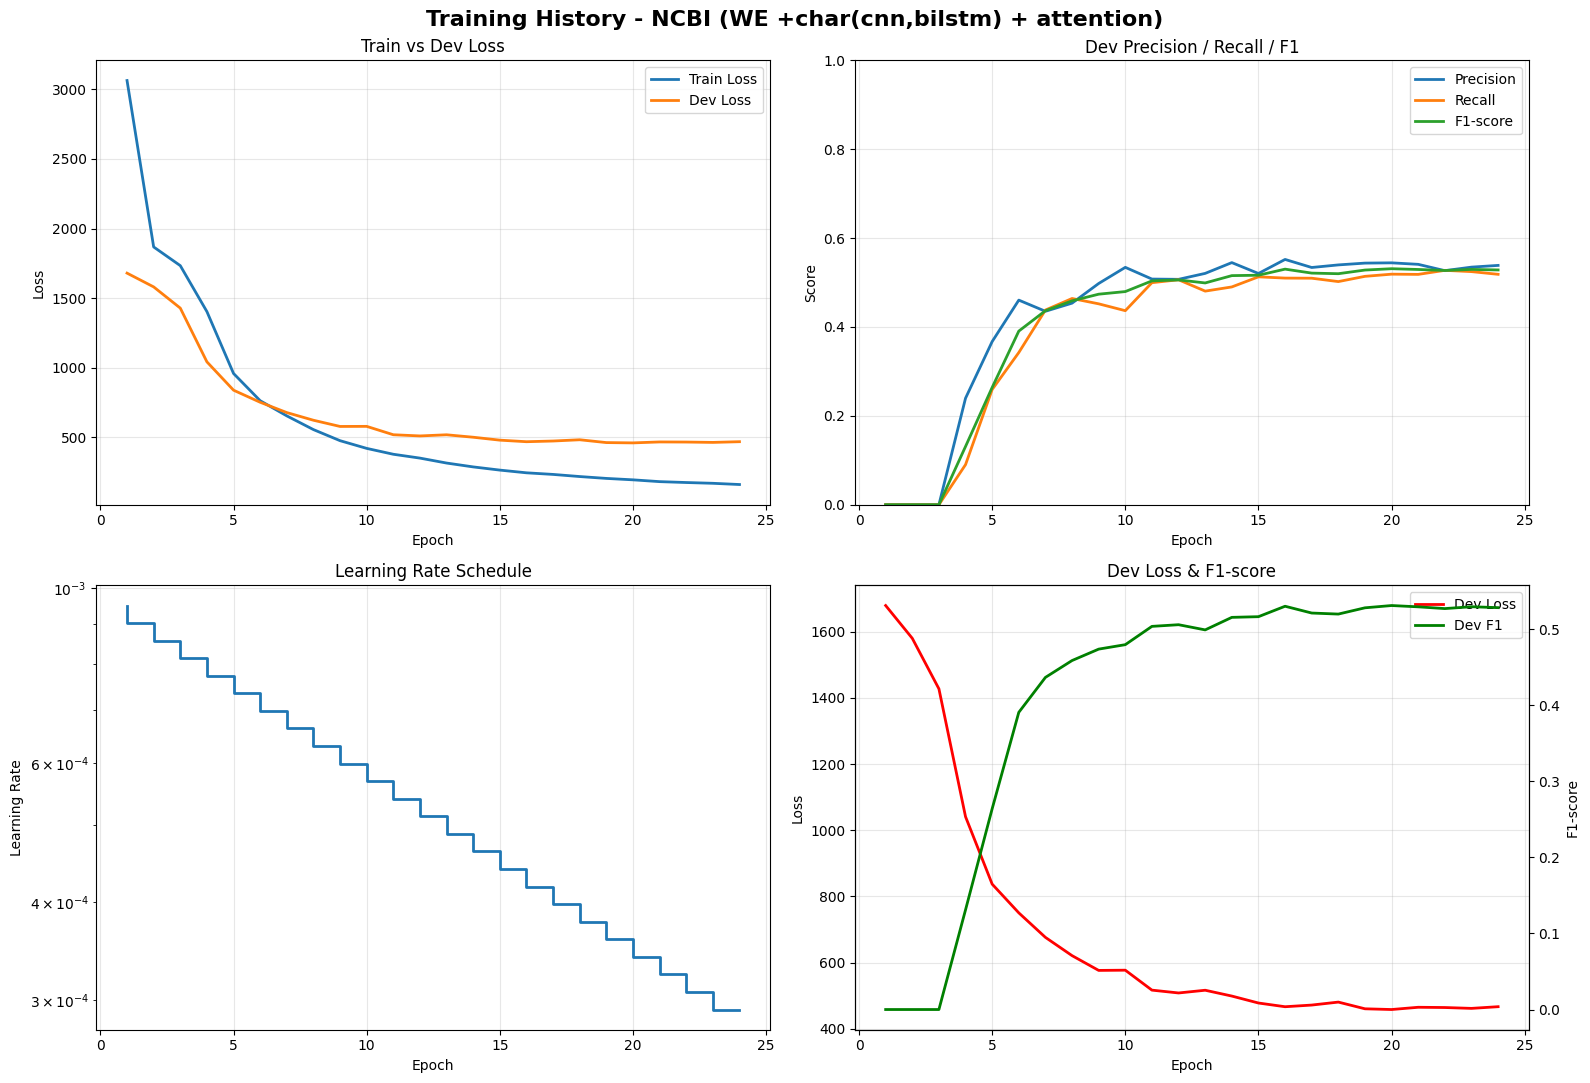


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm) + attention)
Meilleur F1 (dev)       : 0.5311
Meilleure Precision(dev): 0.5520
Meilleur Recall (dev)   : 0.5274
Final train loss        : 158.4768
Final dev loss          : 466.4944
Final learning rate     : 0.000292


In [21]:
plot_training_history(history_we_char_cnn_bilstm_attention, dataset_name="NCBI (WE +char(cnn,bilstm) + attention)")

In [22]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt"
model_we_char__bilstm_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt
Best F1 enregistré: 0.5311
Époque: 19
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O     


Accuracy globale: 0.9784

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'O', 'I-Disease', 'B-Disease'}
  Unique entity tags in predictions: {'O', 'I-Disease', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


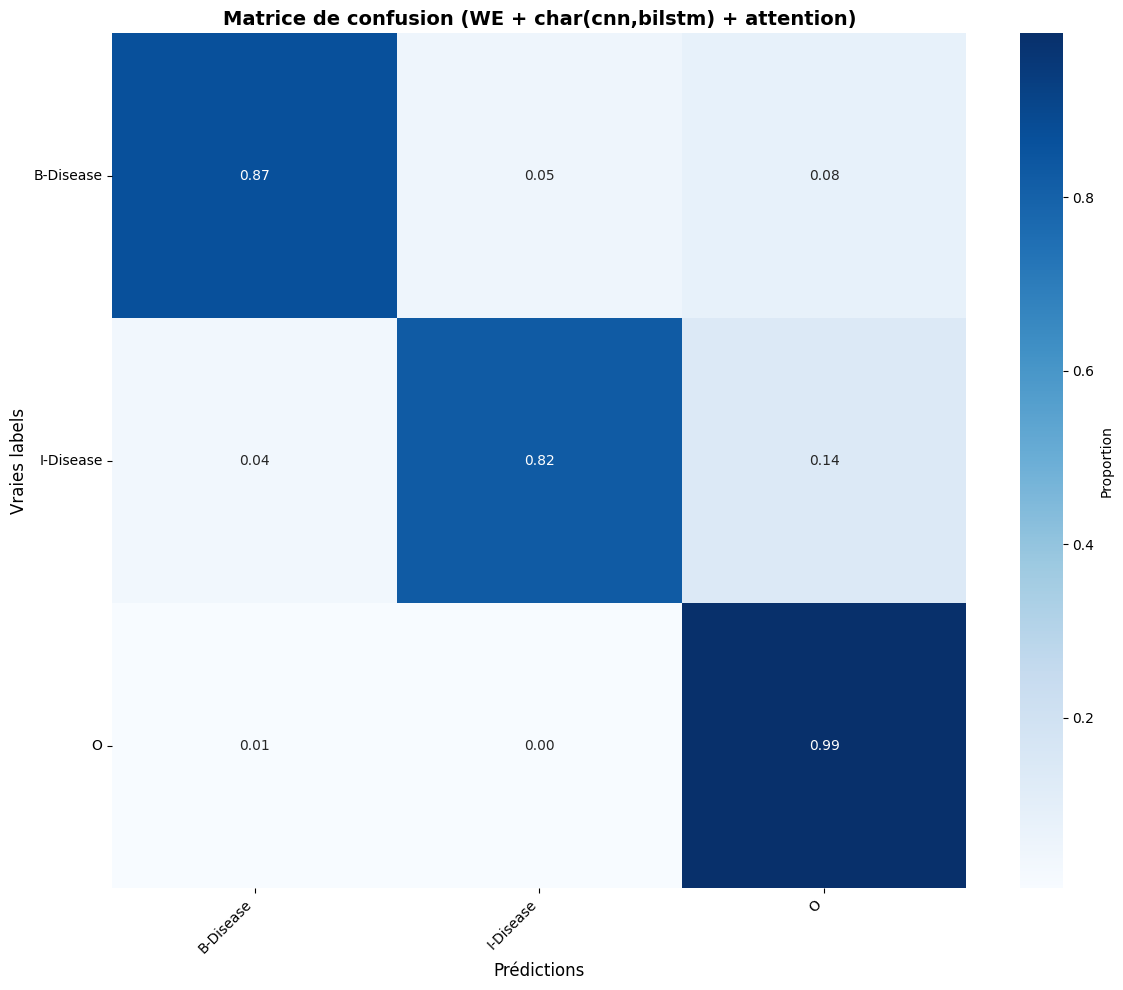

              precision    recall  f1-score   support

   B-Disease       0.79      0.87      0.83       720
   I-Disease       0.86      0.82      0.84       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.88      0.89      0.89     21017
weighted avg       0.98      0.98      0.98     21017



In [23]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention, predictions_we_char__bilstm_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")
if set(predictions_we_char__bilstm_cnn_attention) == set(targets_we_char__bilstm_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention,
        targets=targets_we_char__bilstm_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention[:10])}")

## Combinaison 9 : WE + char(cnn, bilstm) + fully connected network

In [26]:
model_we_char_cnn_bilstm_fc, history_we_char_cnn_bilstm_fc = run_pipeline(
     dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=True,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=6,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 1,429,428


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s]


Epoch 01/40 | Train loss: 3370.7468 | Dev loss: 1851.0684 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Epoch 02/40 | Train loss: 1895.2146 | Dev loss: 1630.6028 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Epoch 03/40 | Train loss: 1810.8429 | Dev loss: 1555.3899 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 04/40 | Train loss: 1691.6228 | Dev loss: 1383.7975 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000815


Training: 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]


Epoch 05/40 | Train loss: 1410.4055 | Dev loss: 1056.6436 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000774


Training: 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]


Epoch 06/40 | Train loss: 1035.7374 | Dev loss: 871.8473 | P: 0.4188 R: 0.1986 F1: 0.2638 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.2638 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 07/40 | Train loss: 815.4117 | Dev loss: 766.7698 | P: 0.4234 R: 0.3226 F1: 0.3662 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.3662 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


Epoch 08/40 | Train loss: 690.3112 | Dev loss: 704.1355 | P: 0.4620 R: 0.3635 F1: 0.4064 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4064 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 09/40 | Train loss: 607.2353 | Dev loss: 675.7749 | P: 0.4865 R: 0.3774 F1: 0.4233 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4233 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]


Epoch 10/40 | Train loss: 549.7823 | Dev loss: 635.2588 | P: 0.5012 R: 0.4058 F1: 0.4478 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4478 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]


Epoch 11/40 | Train loss: 505.5119 | Dev loss: 611.0211 | P: 0.5157 R: 0.4112 F1: 0.4574 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4574 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 12/40 | Train loss: 466.3345 | Dev loss: 585.0560 | P: 0.5190 R: 0.4459 F1: 0.4792 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4792 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


Epoch 13/40 | Train loss: 436.9076 | Dev loss: 589.2989 | P: 0.5293 R: 0.4275 F1: 0.4720 | LR: 0.000513


Training: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 14/40 | Train loss: 414.1721 | Dev loss: 564.6919 | P: 0.5258 R: 0.4527 F1: 0.4857 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.4857 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 15/40 | Train loss: 389.2074 | Dev loss: 572.6453 | P: 0.5397 R: 0.4390 F1: 0.4830 | LR: 0.000463


Training: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 16/40 | Train loss: 370.1934 | Dev loss: 550.7178 | P: 0.5418 R: 0.4505 F1: 0.4914 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.4914 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 17/40 | Train loss: 364.3580 | Dev loss: 532.4744 | P: 0.5396 R: 0.4604 F1: 0.4964 | LR: 0.000418
Meilleur modèle sauvegardé: F1 0.4964 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 18/40 | Train loss: 350.3549 | Dev loss: 537.6434 | P: 0.5455 R: 0.4536 F1: 0.4943 | LR: 0.000397


Training: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


Epoch 19/40 | Train loss: 333.6357 | Dev loss: 530.2652 | P: 0.5360 R: 0.4658 F1: 0.4981 | LR: 0.000377
Meilleur modèle sauvegardé: F1 0.4981 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.43it/s]


Epoch 20/40 | Train loss: 323.2297 | Dev loss: 563.0858 | P: 0.5681 R: 0.4337 F1: 0.4897 | LR: 0.000358


Training: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s]


Epoch 21/40 | Train loss: 320.7845 | Dev loss: 529.8443 | P: 0.5529 R: 0.4609 F1: 0.5019 | LR: 0.000341
Meilleur modèle sauvegardé: F1 0.5019 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]


Epoch 22/40 | Train loss: 307.0129 | Dev loss: 531.0307 | P: 0.5580 R: 0.4561 F1: 0.5009 | LR: 0.000324


Training: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Epoch 23/40 | Train loss: 307.9963 | Dev loss: 528.9730 | P: 0.5583 R: 0.4579 F1: 0.5024 | LR: 0.000307
Meilleur modèle sauvegardé: F1 0.5024 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Epoch 24/40 | Train loss: 297.8100 | Dev loss: 511.2242 | P: 0.5382 R: 0.4829 F1: 0.5088 | LR: 0.000292
Meilleur modèle sauvegardé: F1 0.5088 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Epoch 25/40 | Train loss: 291.2089 | Dev loss: 518.5387 | P: 0.5603 R: 0.4660 F1: 0.5083 | LR: 0.000277


Training: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Epoch 26/40 | Train loss: 288.9904 | Dev loss: 523.8208 | P: 0.5638 R: 0.4632 F1: 0.5076 | LR: 0.000264


Training: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Epoch 27/40 | Train loss: 287.0811 | Dev loss: 519.4454 | P: 0.5656 R: 0.4640 F1: 0.5091 | LR: 0.000250
Meilleur modèle sauvegardé: F1 0.5091 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Epoch 28/40 | Train loss: 276.1411 | Dev loss: 510.4587 | P: 0.5567 R: 0.4786 F1: 0.5142 | LR: 0.000238
Meilleur modèle sauvegardé: F1 0.5142 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 29/40 | Train loss: 271.2967 | Dev loss: 507.8426 | P: 0.5574 R: 0.4794 F1: 0.5152 | LR: 0.000226
Meilleur modèle sauvegardé: F1 0.5152 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 30/40 | Train loss: 269.0551 | Dev loss: 504.5273 | P: 0.5486 R: 0.4874 F1: 0.5160 | LR: 0.000215
Meilleur modèle sauvegardé: F1 0.5160 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]


Epoch 31/40 | Train loss: 264.2628 | Dev loss: 505.0787 | P: 0.5554 R: 0.4865 F1: 0.5184 | LR: 0.000204
Meilleur modèle sauvegardé: F1 0.5184 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


Epoch 32/40 | Train loss: 261.1532 | Dev loss: 510.4149 | P: 0.5598 R: 0.4792 F1: 0.5160 | LR: 0.000194


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 33/40 | Train loss: 256.9723 | Dev loss: 498.2858 | P: 0.5357 R: 0.4926 F1: 0.5132 | LR: 0.000184


Training: 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]


Epoch 34/40 | Train loss: 255.4830 | Dev loss: 500.4616 | P: 0.5571 R: 0.4868 F1: 0.5194 | LR: 0.000175
Meilleur modèle sauvegardé: F1 0.5194 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


Epoch 35/40 | Train loss: 257.6918 | Dev loss: 500.8867 | P: 0.5594 R: 0.4861 F1: 0.5199 | LR: 0.000166
Meilleur modèle sauvegardé: F1 0.5199 (./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Epoch 36/40 | Train loss: 247.2991 | Dev loss: 507.4757 | P: 0.5620 R: 0.4821 F1: 0.5186 | LR: 0.000158


Training: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 37/40 | Train loss: 246.2455 | Dev loss: 503.3652 | P: 0.5542 R: 0.4861 F1: 0.5177 | LR: 0.000150


Training: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 38/40 | Train loss: 245.6780 | Dev loss: 496.3787 | P: 0.5392 R: 0.4940 F1: 0.5155 | LR: 0.000142


Training: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 39/40 | Train loss: 244.8129 | Dev loss: 504.0175 | P: 0.5540 R: 0.4848 F1: 0.5169 | LR: 0.000135


Training: 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]


Epoch 40/40 | Train loss: 240.8222 | Dev loss: 502.7806 | P: 0.5564 R: 0.4831 F1: 0.5169 | LR: 0.000129

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 381.9689
Precision: 0.5675
Recall: 0.5311
F1-score: 0.5482


In [27]:
print_model_layers(model_we_char_cnn_bilstm_fc)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (ReLU)                |            0
fusion.2 (Dropout)             |            0
context_lstm (LSTM)            |      136,192
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,429,428


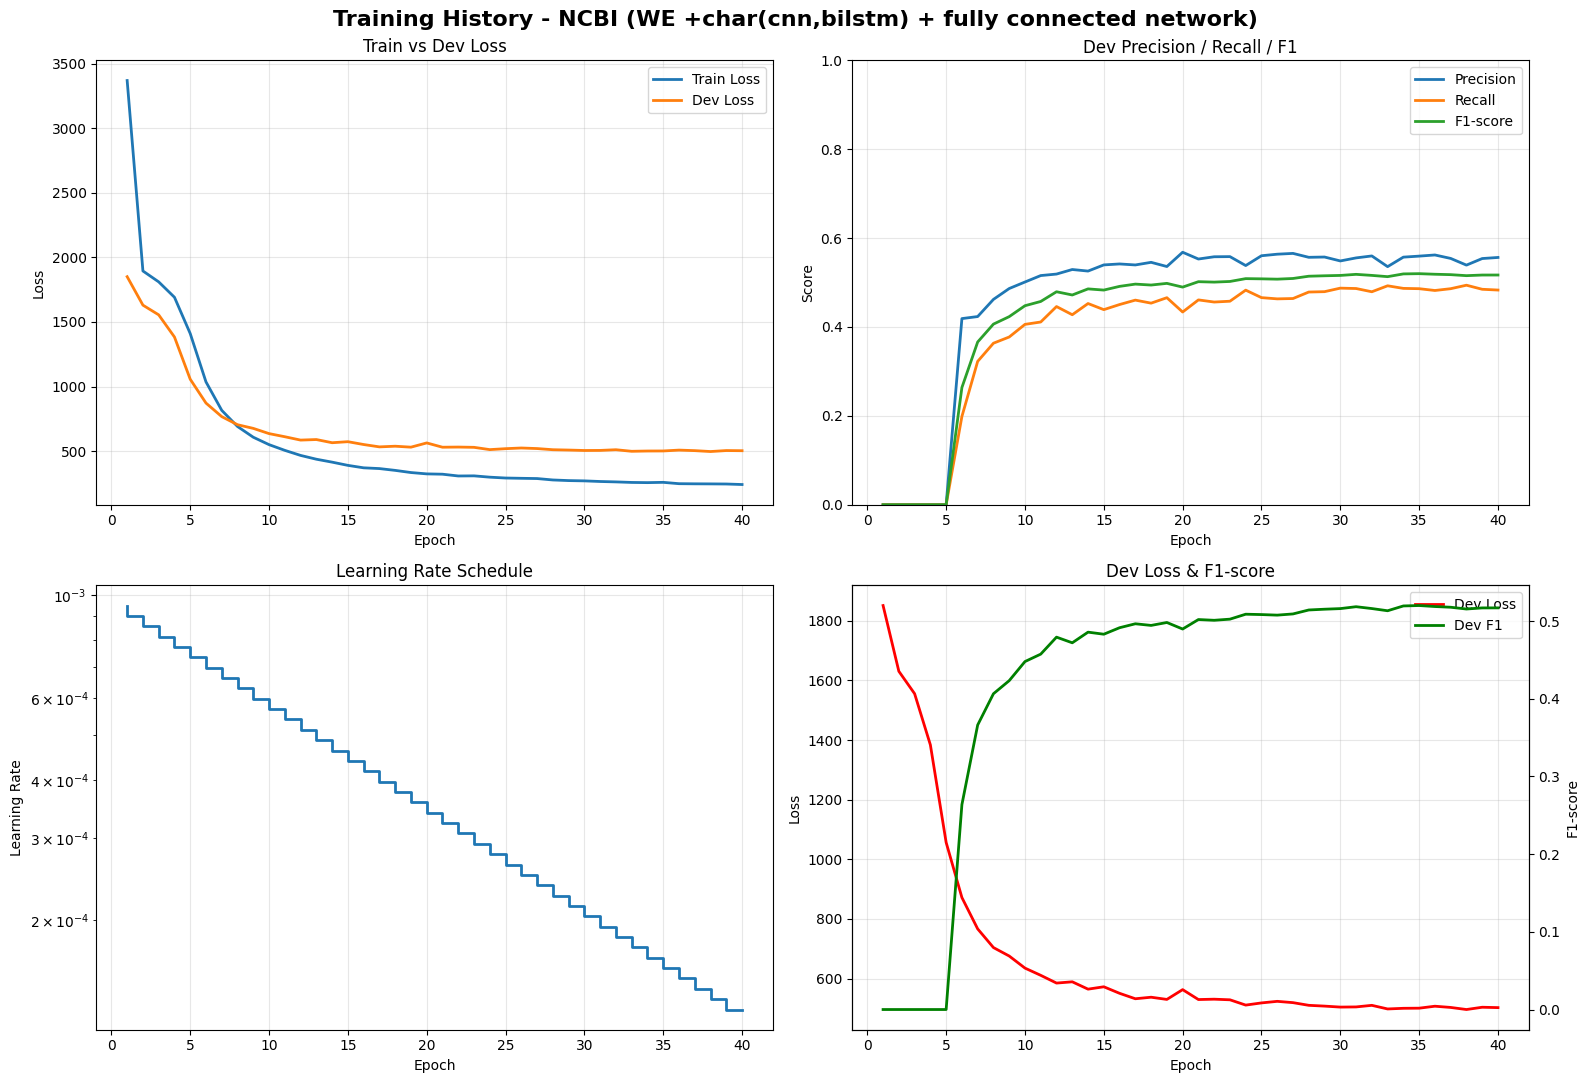


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm) + fully connected network)
Meilleur F1 (dev)       : 0.5199
Meilleure Precision(dev): 0.5681
Meilleur Recall (dev)   : 0.4940
Final train loss        : 240.8222
Final dev loss          : 502.7806
Final learning rate     : 0.000129


In [28]:
plot_training_history(history_we_char_cnn_bilstm_fc, dataset_name="NCBI (WE +char(cnn,bilstm) + fully connected network)")

In [29]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt"
model_we_char__bilstm_cnn_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=True
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt
Best F1 enregistré: 0.5199
Époque: 34
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O            


Accuracy globale: 0.9777

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'O', 'I-Disease', 'B-Disease'}
  Unique entity tags in predictions: {'O', 'I-Disease', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


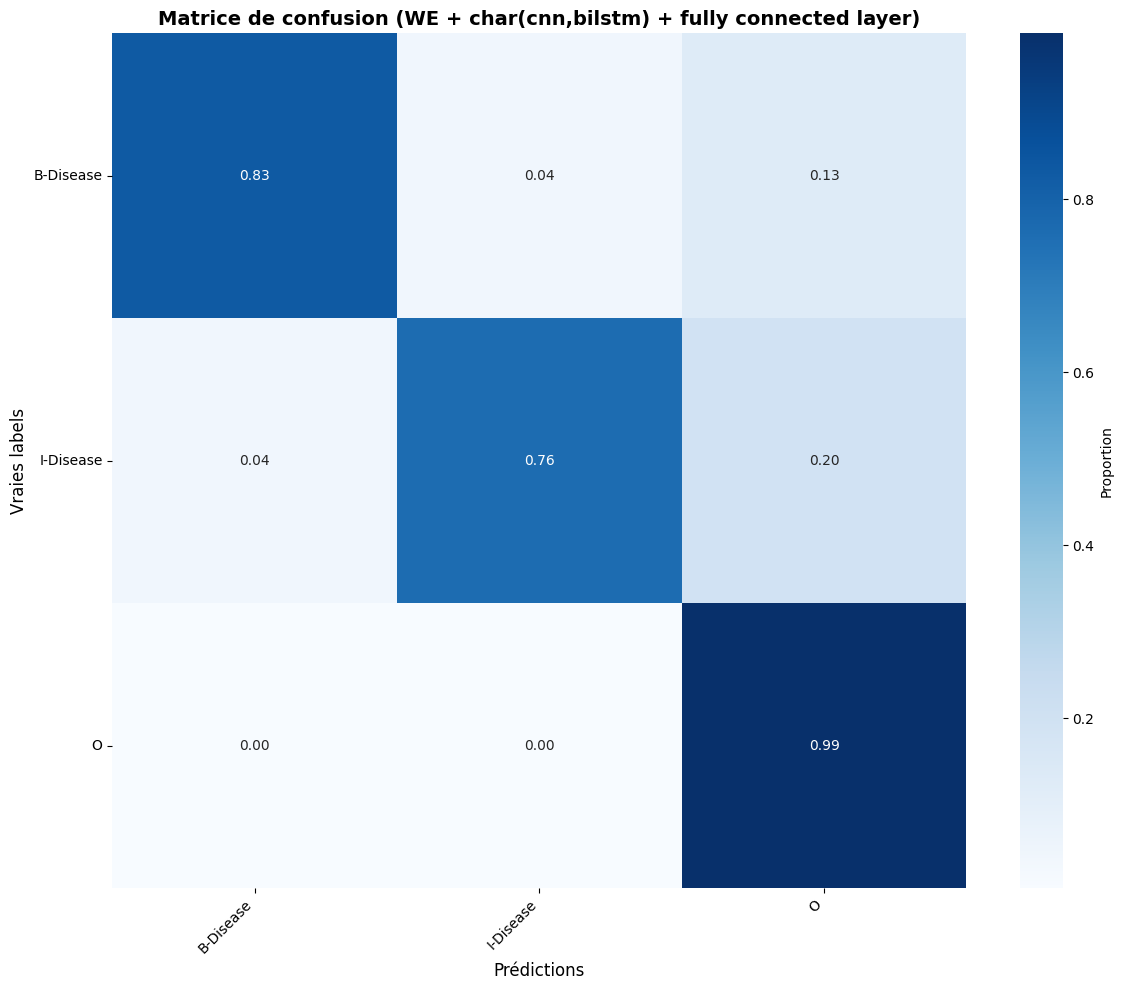

              precision    recall  f1-score   support

   B-Disease       0.83      0.83      0.83       720
   I-Disease       0.87      0.76      0.81       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.90      0.86      0.88     21017
weighted avg       0.98      0.98      0.98     21017



In [30]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_fc, predictions_we_char__bilstm_cnn_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char__bilstm_cnn_fc) == set(targets_we_char__bilstm_cnn_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_fc,
        targets=targets_we_char__bilstm_cnn_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + fully connected layer)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_fc[:10])}")

## Combinaison 10 : WE + char(cnn, bilstm) + fully connected network + attention

In [33]:
model_we_char_cnn_bilstm_fc_attention, history_we_char_cnn_bilstm_fc_attention = run_pipeline(
     dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=6,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 1,462,452


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Training: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


Epoch 01/40 | Train loss: 3106.4556 | Dev loss: 1835.6141 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000950


Training: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


Epoch 02/40 | Train loss: 1913.2962 | Dev loss: 1615.7631 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000902


Training: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


Epoch 03/40 | Train loss: 1826.1920 | Dev loss: 1596.7766 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000857


Training: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


Epoch 04/40 | Train loss: 1778.4653 | Dev loss: 1550.6985 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000815


Training: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


Epoch 05/40 | Train loss: 1664.4802 | Dev loss: 1322.5264 | P: 0.0000 R: 0.0000 F1: 0.0000 | LR: 0.000774


Training: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


Epoch 06/40 | Train loss: 1281.8198 | Dev loss: 895.5865 | P: 0.4001 R: 0.1907 F1: 0.2154 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.2154 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


Epoch 07/40 | Train loss: 848.2340 | Dev loss: 762.2447 | P: 0.4025 R: 0.2790 F1: 0.3232 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.3232 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 08/40 | Train loss: 691.8788 | Dev loss: 747.6548 | P: 0.4381 R: 0.3479 F1: 0.3868 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.3868 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


Epoch 09/40 | Train loss: 593.1987 | Dev loss: 664.6323 | P: 0.4381 R: 0.4090 F1: 0.4200 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.4200 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 10/40 | Train loss: 527.5023 | Dev loss: 622.0859 | P: 0.4841 R: 0.4429 F1: 0.4604 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.4604 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


Epoch 11/40 | Train loss: 463.4949 | Dev loss: 583.8726 | P: 0.4927 R: 0.4633 F1: 0.4772 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4772 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


Epoch 12/40 | Train loss: 416.7649 | Dev loss: 568.7302 | P: 0.5051 R: 0.4704 F1: 0.4861 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4861 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


Epoch 13/40 | Train loss: 390.5673 | Dev loss: 550.9741 | P: 0.5281 R: 0.4656 F1: 0.4946 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.4946 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


Epoch 14/40 | Train loss: 362.0980 | Dev loss: 542.4749 | P: 0.4938 R: 0.5003 F1: 0.4970 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.4970 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


Epoch 15/40 | Train loss: 335.9797 | Dev loss: 536.4919 | P: 0.5473 R: 0.4642 F1: 0.5016 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.5016 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Epoch 16/40 | Train loss: 326.1292 | Dev loss: 545.5098 | P: 0.4760 R: 0.5194 F1: 0.4966 | LR: 0.000440


Training: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


Epoch 17/40 | Train loss: 310.9401 | Dev loss: 526.0794 | P: 0.5389 R: 0.4766 F1: 0.5057 | LR: 0.000418
Meilleur modèle sauvegardé: F1 0.5057 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch 18/40 | Train loss: 294.5106 | Dev loss: 501.9484 | P: 0.5329 R: 0.4943 F1: 0.5128 | LR: 0.000397
Meilleur modèle sauvegardé: F1 0.5128 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


Epoch 19/40 | Train loss: 280.4406 | Dev loss: 503.8397 | P: 0.5173 R: 0.5051 F1: 0.5111 | LR: 0.000377


Training: 100%|██████████| 18/18 [00:12<00:00,  1.41it/s]


Epoch 20/40 | Train loss: 270.7463 | Dev loss: 504.1177 | P: 0.5313 R: 0.4981 F1: 0.5142 | LR: 0.000358
Meilleur modèle sauvegardé: F1 0.5142 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch 21/40 | Train loss: 264.2981 | Dev loss: 503.2783 | P: 0.5450 R: 0.4904 F1: 0.5160 | LR: 0.000341
Meilleur modèle sauvegardé: F1 0.5160 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


Epoch 22/40 | Train loss: 255.6777 | Dev loss: 498.0814 | P: 0.5398 R: 0.4941 F1: 0.5157 | LR: 0.000324


Training: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


Epoch 23/40 | Train loss: 243.2377 | Dev loss: 504.2845 | P: 0.5441 R: 0.4903 F1: 0.5156 | LR: 0.000307


Training: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 24/40 | Train loss: 240.8825 | Dev loss: 483.4422 | P: 0.5315 R: 0.5055 F1: 0.5182 | LR: 0.000292
Meilleur modèle sauvegardé: F1 0.5182 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


Epoch 25/40 | Train loss: 233.6628 | Dev loss: 475.4606 | P: 0.5324 R: 0.5099 F1: 0.5208 | LR: 0.000277
Meilleur modèle sauvegardé: F1 0.5208 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:10<00:00,  1.80it/s]


Epoch 26/40 | Train loss: 226.2657 | Dev loss: 472.7333 | P: 0.5397 R: 0.5094 F1: 0.5241 | LR: 0.000264
Meilleur modèle sauvegardé: F1 0.5241 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


Epoch 27/40 | Train loss: 221.2390 | Dev loss: 475.0323 | P: 0.5317 R: 0.5112 F1: 0.5212 | LR: 0.000250


Training: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch 28/40 | Train loss: 220.2614 | Dev loss: 475.5647 | P: 0.5268 R: 0.5133 F1: 0.5200 | LR: 0.000238


Training: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 29/40 | Train loss: 211.6174 | Dev loss: 472.4407 | P: 0.5360 R: 0.5149 F1: 0.5253 | LR: 0.000226
Meilleur modèle sauvegardé: F1 0.5253 (./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt)


Training: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch 30/40 | Train loss: 212.5853 | Dev loss: 471.6578 | P: 0.5257 R: 0.5198 F1: 0.5226 | LR: 0.000215


Training: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


Epoch 31/40 | Train loss: 205.8928 | Dev loss: 475.7423 | P: 0.5206 R: 0.5175 F1: 0.5190 | LR: 0.000204


Training: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


Epoch 32/40 | Train loss: 205.2551 | Dev loss: 476.5079 | P: 0.5186 R: 0.5221 F1: 0.5203 | LR: 0.000194


Training: 100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 33/40 | Train loss: 198.8351 | Dev loss: 467.2888 | P: 0.5254 R: 0.5191 F1: 0.5222 | LR: 0.000184


Training: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Epoch 34/40 | Train loss: 198.7588 | Dev loss: 481.3313 | P: 0.5326 R: 0.5143 F1: 0.5233 | LR: 0.000175


Training: 100%|██████████| 18/18 [00:13<00:00,  1.34it/s]


Epoch 35/40 | Train loss: 190.0755 | Dev loss: 476.9247 | P: 0.5368 R: 0.5136 F1: 0.5250 | LR: 0.000166
Early stopping triggered après 35 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 361.6045
Precision: 0.5552
Recall: 0.5597
F1-score: 0.5573


In [34]:
print_model_layers(model_we_char_cnn_bilstm_fc_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,149,400
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (ReLU)                |            0
fusion.2 (Dropout)             |            0
context_lstm (LSTM)            |      136,192
attention_layer.W (Linear)     |          128
attention_projection (Linear)  |       32,896
emission (Linear)              |          516
crf (CRF)                      |           24
---------------------------------------------
Total parameters               |    1,462,452


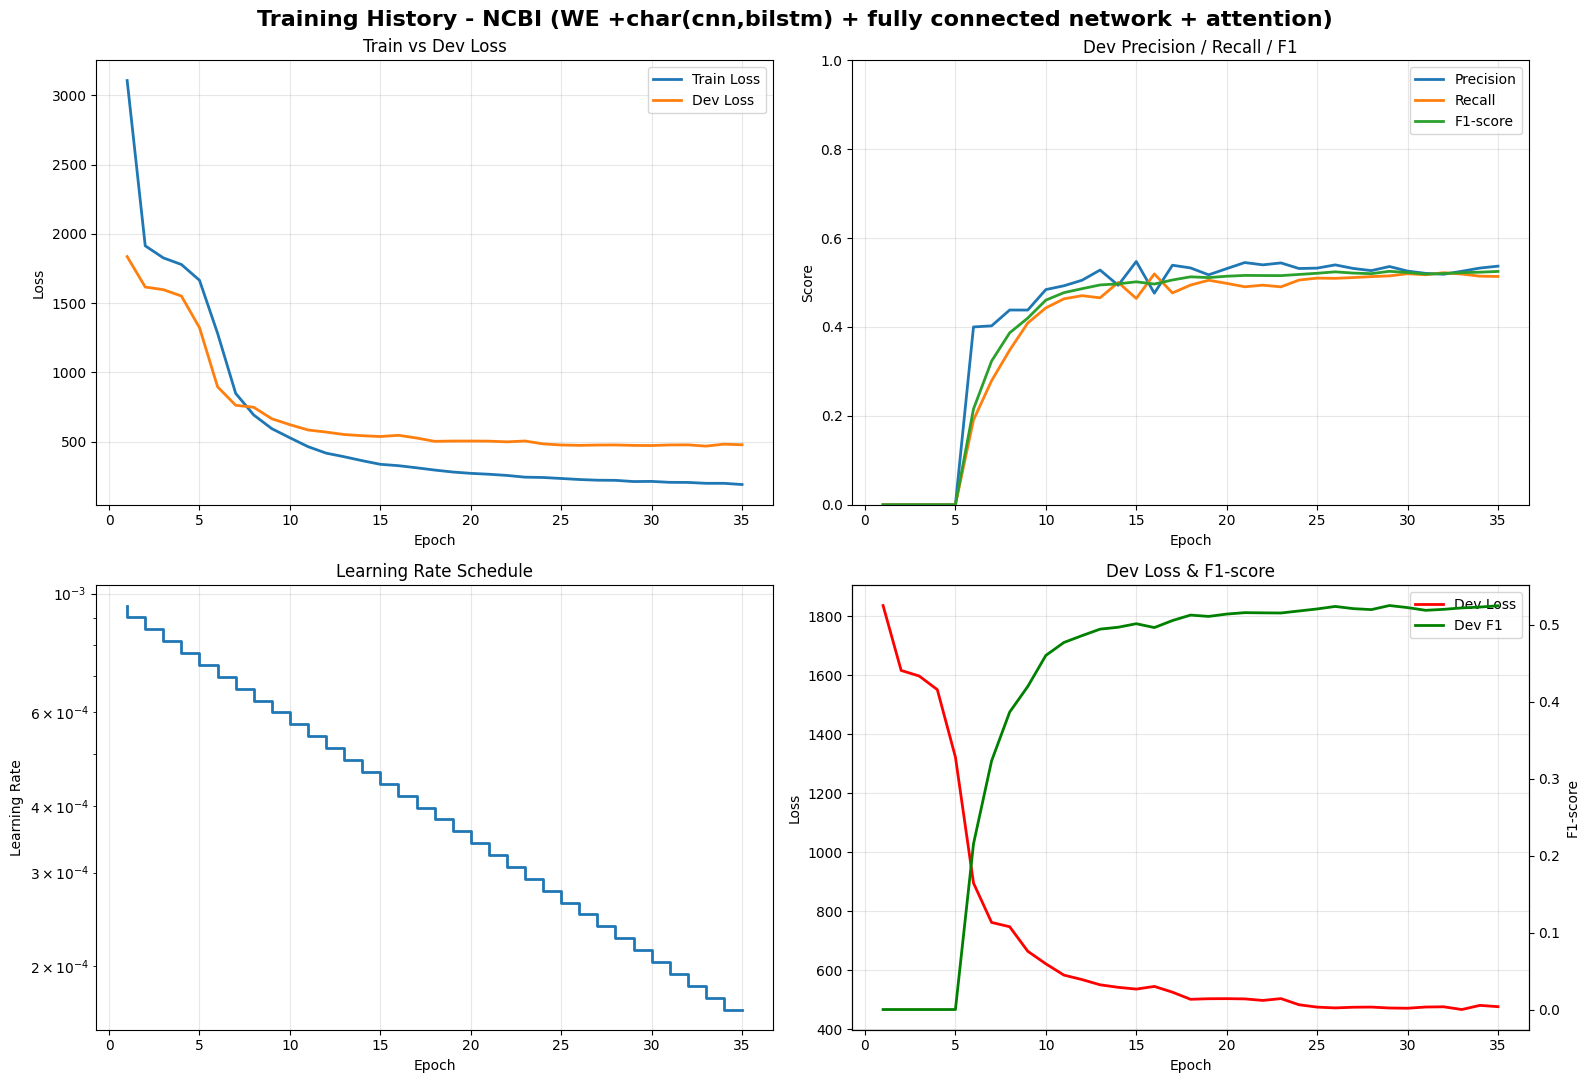


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm) + fully connected network + attention)
Meilleur F1 (dev)       : 0.5253
Meilleure Precision(dev): 0.5473
Meilleur Recall (dev)   : 0.5221
Final train loss        : 190.0755
Final dev loss          : 476.9247
Final learning rate     : 0.000166


In [36]:
plot_training_history(history_we_char_cnn_bilstm_fc_attention, dataset_name="NCBI (WE +char(cnn,bilstm) + fully connected network + attention)")

In [37]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt"
model_we_char__bilstm_cnn_attention_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt
Best F1 enregistré: 0.5253
Époque: 28
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | O  


Accuracy globale: 0.9789

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 21017
  Entity tokens: 21017
  Unique entity tags in targets: {'O', 'I-Disease', 'B-Disease'}
  Unique entity tags in predictions: {'O', 'I-Disease', 'B-Disease'}
  Tags valides à plotter: ['B-Disease', 'I-Disease', 'O']


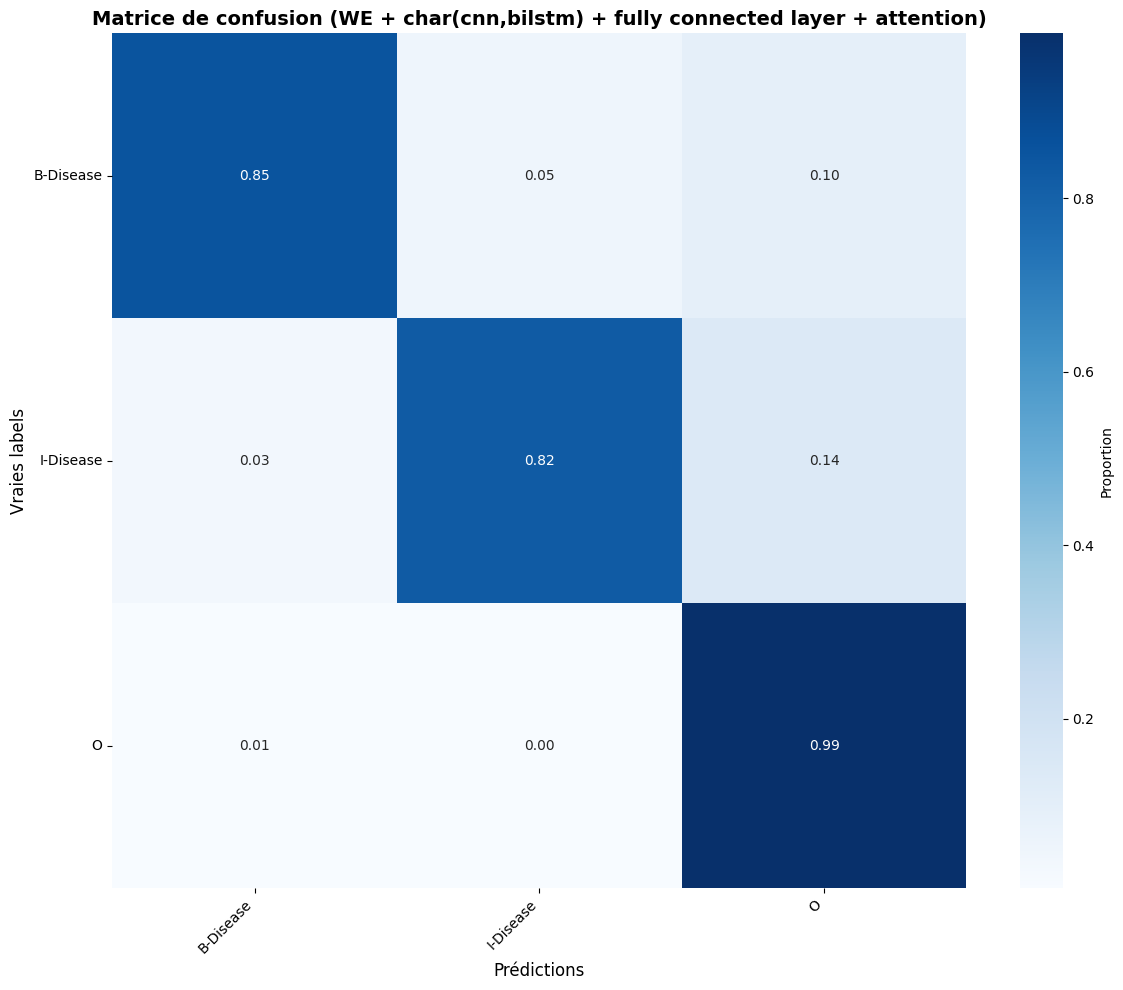

              precision    recall  f1-score   support

   B-Disease       0.82      0.85      0.84       720
   I-Disease       0.84      0.82      0.83       822
           O       0.99      0.99      0.99     19475

    accuracy                           0.98     21017
   macro avg       0.89      0.89      0.89     21017
weighted avg       0.98      0.98      0.98     21017



In [38]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc, predictions_we_char__bilstm_cnn_attention_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char__bilstm_cnn_attention_fc) == set(targets_we_char__bilstm_cnn_attention_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention_fc,
        targets=targets_we_char__bilstm_cnn_attention_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + fully connected layer + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc[:10])}")

Test on a set of examples

In [ ]:
import torch

# =========================
# 1. Chargement checkpoint
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt"

ckpt = torch.load(checkpoint_path, map_location=device)

# =========================
# 2. Récupération EXACTE des objets du training
# =========================
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_ncbi["train_loader"]
vocab        = results_ncbi["vocab"]
char_vocab   = results_ncbi["char_vocab"]
tag_to_idx   = results_ncbi["tag_to_idx"]
idx_to_tag   = results_ncbi["idx_to_tag"]

# =========================
# 3. Reconstruction du modèle (IDENTIQUE au training)
# =========================
model = CombinatorialNER(
    dataset="NCBI",
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_ncbi["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=128,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# =========================
# 4. Fonction de prédiction CORRECTE
# =========================
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



test_data = [
    # Example 1
    (["the", "hereditary", "breast", "and", "ovarian", "cancer", "syndrome", "is", "associated", "with", "a", "high", "frequency", "of", "brca1", "mutations", "."],
     ["O", "B-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),

    # Example 2
    (["patients", "with", "BRCA1", "mutation", "show", "increased", "risk"],
     ["O", "O", "B-Disease", "I-Disease", "O", "O", "O"]),

    # Example 3
    (["the", "prevalence", "of", "hereditary", "breast", "cancer", "is", "high", "in", "certain", "populations"],
     ["O", "O", "O", "B-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O"])
]




# =========================
# 6. Évaluation lisible
# =========================
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")

Example 1
Token           Gold            Predicted      
--------------------------------------------------
the             O               O              
hereditary      B-Disease       B-Disease      
breast          I-Disease       I-Disease      
and             I-Disease       I-Disease      
ovarian         I-Disease       I-Disease      
cancer          I-Disease       I-Disease      
syndrome        I-Disease       I-Disease      
is              O               O              
associated      O               O              
with            O               O              
a               O               O              
high            O               O              
frequency       O               O              
of              O               O              
brca1           O               O              
mutations       O               O              
.               O               O              

Token accuracy (sentence): 1.0000

Example 2
Token           Gold         

In [7]:
# Ajoute ce debug dans load_ncbi_components()
import torch

checkpoint_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt"
ckpt = torch.load(checkpoint_path, map_location='cpu')

# Vérifier la taille des matrices
if 'model_state_dict' in ckpt:
    print(f"Emission weight shape: {ckpt['model_state_dict']['emission.weight'].shape}")
    print(f"Num classes: {ckpt['model_state_dict']['emission.weight'].shape[0]}")

Emission weight shape: torch.Size([4, 128])
Num classes: 4
